In [211]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sqlite3
from collections import defaultdict
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [72]:
conn = sqlite3.connect('mental_health.sqlite')

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()
table_names = [table[0] for table in tables]

In [73]:
table_names

['Answer', 'Question', 'Survey']

## Initial Analysis with SQL

In [74]:
def count_rows(table_name):
    query = f"SELECT COUNT(*) FROM {table_name};"
    result = conn.execute(query).fetchone()[0]
    return result

answer_row_count = count_rows('Answer')
question_row_count = count_rows('Question')
survey_row_count = count_rows('Survey')

answer_row_count, question_row_count, survey_row_count

(236898, 105, 5)

> The "Answer" table has the most rows, as it contains the responses from participants across various survey years and questions. The "Question" and "Survey" tables have fewer rows, reflecting the number of unique questions asked and surveys conducted, respectively.

In [75]:
def view_table(table_name, limit=5):
    query = f"SELECT * FROM {table_name} LIMIT {limit};"
    result = pd.read_sql_query(query, conn)
    return result

def get_column_info(table_name):
    query = f"PRAGMA table_info({table_name});"
    result = pd.read_sql_query(query, conn)
    return result

answer_first_few_rows = view_table('Answer')
answer_column_info = get_column_info('Answer')

answer_first_few_rows, answer_column_info

(  AnswerText  SurveyID  UserID  QuestionID
 0         37      2014       1           1
 1         44      2014       2           1
 2         32      2014       3           1
 3         31      2014       4           1
 4         31      2014       5           1,
    cid        name            type  notnull dflt_value  pk
 0    0  AnswerText  VARCHAR(10000)        0       None   0
 1    1    SurveyID         INTEGER        0       None   0
 2    2      UserID         INTEGER        0       None   0
 3    3  QuestionID         INTEGER        0       None   0)

> Column Information:
The table has four columns: AnswerText, SurveyID, UserID, and QuestionID.

- AnswerText: Stores the responses as text. The type is VARCHAR(10000).
- SurveyID: Stores the survey year as an integer.
- UserID: Stores the user identifier as an integer.
- QuestionID: Stores the question identifier as an integer.

> First Few Rows:

- The "Answer" table contains responses from different users across various survey years and questions.
- The first few rows show responses to the age question (Question ID: 1) from different users.

In [76]:
question_first_few_rows = view_table('Question')
question_column_info = get_column_info('Question')

question_first_few_rows, question_column_info

(                                        questiontext  questionid
 0                                  What is your age?           1
 1                               What is your gender?           2
 2                       What country do you live in?           3
 3  If you live in the United States, which state ...           4
 4                             Are you self-employed?           5,
    cid          name           type  notnull dflt_value  pk
 0    0  questiontext  VARCHAR(1000)        0       None   0
 1    1    questionid        INTEGER        0       None   0)

> Column Information:
The table has two columns: questiontext and questionid.
- questiontext: Stores the text of the survey questions. The type is VARCHAR(1000).
- questionid: Stores the unique identifier for each question as an integer.

> First Few Rows:
- The "Question" table lists the survey questions along with their identifiers.
- The first few rows show questions related to demographic information and employment status.

In [77]:
survey_first_few_rows = view_table('Survey')
survey_column_info = get_column_info('Survey')

survey_first_few_rows, survey_column_info

(   SurveyID                    Description
 0      2014  mental health survey for 2014
 1      2016  mental health survey for 2016
 2      2017  mental health survey for 2017
 3      2018  mental health survey for 2018
 4      2019  mental health survey for 2019,
    cid         name          type  notnull dflt_value  pk
 0    0     SurveyID       INTEGER        1       None   1
 1    1  Description  VARCHAR(255)        0       None   0)

> Column Information:
The table has two columns: SurveyID and Description.
- SurveyID: Stores the survey year as an integer. It is the primary key and cannot be null.
- Description: Stores a text description of the survey. The type is VARCHAR(255).

> First Few Rows:
- The "Survey" table contains metadata about each survey conducted.
- The first few rows show the survey years and their descriptions.

In [78]:
def execute_query(query):
    result = pd.read_sql_query(query, conn)
    return result

In [79]:
unique_users_per_year = """
SELECT SurveyID, COUNT(DISTINCT UserID) as UniqueUserCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""
execute_query(unique_users_per_year)

,SurveyID,UniqueUserCount
0,2014,1260
1,2016,1433
2,2017,756
3,2018,417
4,2019,352


In [80]:
unique_questions_per_year = """
SELECT SurveyID, COUNT(DISTINCT QuestionID) as UniqueQuestionCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""
execute_query(unique_questions_per_year)

,SurveyID,UniqueQuestionCount
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


In [81]:
common_questions_across_years = """
WITH QuestionCount AS (
    SELECT QuestionID, COUNT(DISTINCT SurveyID) as SurveyCount
    FROM Answer
    GROUP BY QuestionID
)
SELECT q.questionid, q.questiontext, qc.SurveyCount
FROM Question q
JOIN QuestionCount qc ON q.questionid = qc.QuestionID
WHERE qc.SurveyCount = (SELECT COUNT(DISTINCT SurveyID) FROM Answer);
"""
execute_query(common_questions_across_years)

,questionid,questiontext,SurveyCount
0,1,What is your age?,5
1,2,What is your gender?,5
2,3,What country do you live in?,5
3,4,"If you live in the United States, which state ...",5
4,5,Are you self-employed?,5
5,6,Do you have a family history of mental illness?,5
6,7,Have you ever sought treatment for a mental he...,5
7,8,How many employees does your company or organi...,5
8,9,Is your employer primarily a tech company/orga...,5
9,10,Does your employer provide mental health benef...,5


In [82]:
questions_and_years = """
SELECT q.questionid, q.questiontext, GROUP_CONCAT(DISTINCT a.SurveyID) as SurveyYears
FROM Answer a
JOIN Question q ON a.QuestionID = q.questionid
GROUP BY a.QuestionID
ORDER BY a.QuestionID;
"""
execute_query(questions_and_years)

,questionid,questiontext,SurveyYears
0,1,What is your age?,"2014,2016,2017,2018,2019"
1,2,What is your gender?,"2014,2016,2017,2018,2019"
2,3,What country do you live in?,"2014,2016,2017,2018,2019"
3,4,"If you live in the United States, which state ...","2014,2016,2017,2018,2019"
4,5,Are you self-employed?,"2014,2016,2017,2018,2019"
...,...,...,...
100,114,Do you think that team members/co-workers woul...,2016
101,115,"If yes, what condition(s) have you been diagno...",2016
102,116,"If maybe, what condition(s) do you believe you...",2016
103,117,Which of the following best describes your wor...,2016


In [83]:
unique_questions_per_year = """
SELECT SurveyID, GROUP_CONCAT(DISTINCT QuestionID) as Questions
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""
questions_per_year = execute_query(unique_questions_per_year)

questions_per_year_dict = {row['SurveyID']: set(map(int, row['Questions'].split(','))) for index, row in questions_per_year.iterrows()}

percentage_change = defaultdict(lambda: "N/A")

sorted_years = sorted(questions_per_year_dict.keys())
for i in range(1, len(sorted_years)):
    previous_year = sorted_years[i - 1]
    current_year = sorted_years[i]
    
    previous_questions = questions_per_year_dict[previous_year]
    current_questions = questions_per_year_dict[current_year]
    
    added_questions = current_questions - previous_questions
    removed_questions = previous_questions - current_questions
    
    total_changes = len(added_questions) + len(removed_questions)
    percentage_change[current_year] = (total_changes / len(previous_questions)) * 100

percentage_change

defaultdict(<function __main__.<lambda>()>,
            {2016: 223.0769230769231,
             2017: 83.33333333333334,
             2018: 0.0,
             2019: 0.0})

- From 2014 to 2016: 223.08% of questions changed
- From 2016 to 2017: 83.33% of questions changed
- From 2017 to 2018: 0.00% of questions changed (no change)
- From 2018 to 2019: 0.00% of questions changed (no change)

> The percentage is over 100% from 2014 to 2016 because many new questions were added in 2016, resulting in a significant increase in the total number of questions. From 2017 onwards, the set of questions remained stable, with no changes observed in the subsequent years.

In [84]:
answer_with_questions = """
SELECT a.*, q.questiontext
FROM Answer a
JOIN Question q ON a.QuestionID = q.questionid;
"""
execute_query(answer_with_questions)

,AnswerText,SurveyID,UserID,QuestionID,questiontext
0,37,2014,1,1,What is your age?
1,44,2014,2,1,What is your age?
2,32,2014,3,1,What is your age?
3,31,2014,4,1,What is your age?
4,31,2014,5,1,What is your age?
...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...
236894,Support,2016,2690,117,Which of the following best describes your wor...
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...


In [85]:
answer_with_questions = pd.read_sql_query(answer_with_questions, conn)

file_path = 'C:/Users/Liberty/Desktop/Untitled Folder/Turing College - Project 5 - Mental Health in the Tech Industry/mental_health.csv'

answer_with_questions.to_csv(file_path, index=False)

conn.close()

## Initial Analysis with Pandas

In [86]:
mental_health_df = pd.read_csv('mental_health.csv')

In [87]:
def initial_analysis(df):
    """
    Runs several pandas functions for initial analysis.
    """
    display(df.shape)
    display(df.head())
    display(df.tail())
    display(df.columns)
    display(df.info())
    [print(f'{i} contains {df[i].nunique()} unique values') for i in df.columns]
    [print(f'The dataframe contains {df.duplicated().sum()} duplicated values')]
    display(df.describe())

In [88]:
initial_analysis(mental_health_df)

(236898, 5)

,AnswerText,SurveyID,UserID,QuestionID,questiontext
0,37,2014,1,1,What is your age?
1,44,2014,2,1,What is your age?
2,32,2014,3,1,What is your age?
3,31,2014,4,1,What is your age?
4,31,2014,5,1,What is your age?


,AnswerText,SurveyID,UserID,QuestionID,questiontext
236893,Other,2016,2689,117,Which of the following best describes your wor...
236894,Support,2016,2690,117,Which of the following best describes your wor...
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...
236897,Other,2016,2693,117,Which of the following best describes your wor...


Index(['AnswerText', 'SurveyID', 'UserID', 'QuestionID', 'questiontext'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   AnswerText    236893 non-null  object
 1   SurveyID      236898 non-null  int64 
 2   UserID        236898 non-null  int64 
 3   QuestionID    236898 non-null  int64 
 4   questiontext  236898 non-null  object
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


None

AnswerText contains 4214 unique values
SurveyID contains 5 unique values
UserID contains 4218 unique values
QuestionID contains 105 unique values
questiontext contains 105 unique values
The dataframe contains 0 duplicated values


,SurveyID,UserID,QuestionID
count,236898.000000,236898.000000,236898.000000
mean,2016.572297,2514.516619,48.655898
std,1.421134,1099.462747,36.126215
min,2014.000000,1.000000,1.000000
25%,2016.000000,1691.000000,15.000000
50%,2016.000000,2652.000000,48.000000
75%,2017.000000,3439.000000,80.000000
max,2019.000000,4218.000000,118.000000


> The data is largely clean with no duplicates, correct data types, no null values, and nothing that looks super out of place upon initial inspection. 

> We have 5 features, 2 of them categorical and 3 of them numerical. 

> There are several things I want to do in order to make the data easier to extract interesting insights from. We know that every year has 12 questions in common, so I want to transform the data and add each of those common questions as columns. Additionally, I want to rename the column names and remove the questionid column.

## Data Cleaning

Issues 
- data in it's current form is difficult to extract insights from and we don't have a baseline of information per respondent
- column names are unclear or inconsistently formatted
- questionid column is unnecessary 
- the new columns created will need updated data types
- the new columns created will require additional analysis and cleaning

Solutions 
- turn the 12 common questions across all years into their own columns
- change column names for clarity
- remove questionid column 
- change column types for newly created columns
- define further issues and solutions to data after tranformation for new columns


In [89]:
mental_health_to_clean = mental_health_df.copy()

In [90]:
mental_health_to_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   AnswerText    236893 non-null  object
 1   SurveyID      236898 non-null  int64 
 2   UserID        236898 non-null  int64 
 3   QuestionID    236898 non-null  int64 
 4   questiontext  236898 non-null  object
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


### turn the 12 common questions across all years into their own columns

In [91]:
common_questions_ids = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [92]:
mental_health_to_clean['QuestionID'] = mental_health_to_clean['QuestionID'].astype(str)

pivoted_data = mental_health_to_clean[mental_health_to_clean['QuestionID'].isin(common_questions_ids)].pivot_table(
    index=['SurveyID', 'UserID'], 
    columns='QuestionID', 
    values='AnswerText', 
    aggfunc='first'
).reset_index()

In [93]:
pivoted_data.head()

QuestionID,SurveyID,UserID,1,10,11,12,2,3,4,5,6,7,8,9
0,2014,1,37,Yes,Yes,No,Female,United States,Illinois,-1,No,1,6-25,1
1,2014,2,44,Don't know,Don't know,No,Male,United States,Indiana,-1,No,0,More than 1000,0
2,2014,3,32,No,Don't know,Yes,Male,Canada,-1,-1,No,0,6-25,1
3,2014,4,31,No,No,Maybe,Male,United Kingdom,-1,-1,Yes,1,26-100,1
4,2014,5,31,Yes,Don't know,Yes,Male,United States,Texas,-1,No,0,100-500,1


In [94]:
filtered_data = mental_health_to_clean[~((mental_health_to_clean['QuestionID'].isin(common_questions_ids)) & (mental_health_to_clean['UserID'].isin(pivoted_data['UserID'])) & (mental_health_to_clean['SurveyID'].isin(pivoted_data['SurveyID'])))]

In [95]:
transformed_data = pd.merge(filtered_data, pivoted_data, on=['SurveyID', 'UserID'], how='left')

In [96]:
transformed_data.head()

,AnswerText,SurveyID,UserID,QuestionID,questiontext,1,10,11,12,2,3,4,5,6,7,8,9
0,No,2014,1,90,Do you think that discussing a physical health...,37,Yes,Yes,No,Female,United States,Illinois,-1,No,1,6-25,1
1,No,2014,2,90,Do you think that discussing a physical health...,44,Don't know,Don't know,No,Male,United States,Indiana,-1,No,0,More than 1000,0
2,No,2014,3,90,Do you think that discussing a physical health...,32,No,Don't know,Yes,Male,Canada,-1,-1,No,0,6-25,1
3,Yes,2014,4,90,Do you think that discussing a physical health...,31,No,No,Maybe,Male,United Kingdom,-1,-1,Yes,1,26-100,1
4,No,2014,5,90,Do you think that discussing a physical health...,31,Yes,Don't know,Yes,Male,United States,Texas,-1,No,0,100-500,1


In [97]:
mental_health_to_clean = transformed_data.copy()

### continuing with the rest of the cleaning

In [98]:
mental_health_to_clean.columns

Index(['AnswerText', 'SurveyID', 'UserID', 'QuestionID', 'questiontext', '1',
       '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

> Question IDs with their full question text

- 1: 
What is your age?
- 2: 
What is your gender?
- 3: 
What country do you live in?
- 4: 
If you live in the United States, which state or territory do you live in?
- 5: 
Are you self-employed?
- 6: 
Do you have a family history of mental illness?
- 7: 
Have you ever sought treatment for a mental health condition?
- 8: 
How many employees does your company or organization have?
- 9: 
Is your employer primarily a tech company/organization?
- 10: 
Does your employer provide mental health benefits?
- 11: 
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
- 12: 
Would you bring up a mental health issue with a potential employer in an interview?

In [99]:
mental_health_to_clean = mental_health_to_clean.rename(columns=
                                                       {
                                                        'AnswerText': 'answer', 
                                                        'SurveyID': 'survey_year',
                                                        'UserID': 'user_id', 
                                                        'questiontext': 'question',
                                                        '1': 'age', 
                                                        '2': 'gender',
                                                        '3': 'country', 
                                                        '4': 'us_state',
                                                        '5': 'self_employed', 
                                                        '6': 'fam_mh_illness_history',
                                                        '7': 'sought_mh_treatment', 
                                                        '8': 'employer_size',
                                                        '9': 'employer_tech', 
                                                        '10': 'employer_mh_benefits',
                                                        '11': 'anonymity', 
                                                        '12': 'mh_interview'
                                                        })

In [100]:
mental_health_to_clean = mental_health_to_clean.drop('QuestionID', axis=1)

In [101]:
mental_health_to_clean.head()

,answer,survey_year,user_id,question,age,employer_mh_benefits,anonymity,mh_interview,gender,country,us_state,self_employed,fam_mh_illness_history,sought_mh_treatment,employer_size,employer_tech
0,No,2014,1,Do you think that discussing a physical health...,37,Yes,Yes,No,Female,United States,Illinois,-1,No,1,6-25,1
1,No,2014,2,Do you think that discussing a physical health...,44,Don't know,Don't know,No,Male,United States,Indiana,-1,No,0,More than 1000,0
2,No,2014,3,Do you think that discussing a physical health...,32,No,Don't know,Yes,Male,Canada,-1,-1,No,0,6-25,1
3,Yes,2014,4,Do you think that discussing a physical health...,31,No,No,Maybe,Male,United Kingdom,-1,-1,Yes,1,26-100,1
4,No,2014,5,Do you think that discussing a physical health...,31,Yes,Don't know,Yes,Male,United States,Texas,-1,No,0,100-500,1


In [102]:
mental_health_to_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186282 entries, 0 to 186281
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   answer                  186280 non-null  object
 1   survey_year             186282 non-null  int64 
 2   user_id                 186282 non-null  int64 
 3   question                186282 non-null  object
 4   age                     186282 non-null  object
 5   employer_mh_benefits    186282 non-null  object
 6   anonymity               186282 non-null  object
 7   mh_interview            186282 non-null  object
 8   gender                  186090 non-null  object
 9   country                 186282 non-null  object
 10  us_state                186282 non-null  object
 11  self_employed           186282 non-null  object
 12  fam_mh_illness_history  186282 non-null  object
 13  sought_mh_treatment     186282 non-null  object
 14  employer_size           186282 non-n

> now that the transformation of the data is complete, I want to make a copy before we continue on with the cleaning in case something goes wrong

In [112]:
mental_health_to_cleanv2 = mental_health_to_clean.copy()

### additional cleaning for new columns

Issues 
- the us_state column has -1 as a response
- the country column has many different ways of saying the same country
- some columns use yes/no/maybe while some use 0/1/-1, and others use a mixture of the two 
- data types are wrong for some columns

Solutions 
- change -1 to unknown if the country is United States and change it to N/A if the country is not United States
- change columns that have country name variations to be all the same
- change columns using 0/1/-1 or a mix of words and numbers for clarity
- fix column data types


In [113]:
def standardize_country_name(country):
    if pd.isnull(country) or country == '-1':
        return "unknown"
    
    country = country.strip()
    
    us_variations = ['us', 'usa', 'united states', 'united states of america']
    if country.lower() in us_variations:
        return "United States"
    
    uk_variations = ['uk', 'united kingdom', 'england', 'scotland', 'wales', 'northern ireland']
    if country.lower() in uk_variations:
        return "United Kingdom"
    
    return country

mental_health_to_cleanv2['country'] = mental_health_to_cleanv2['country'].apply(standardize_country_name)

mental_health_to_cleanv2['country'].unique()

array(['United States', 'Canada', 'United Kingdom', 'Bulgaria', 'France',
       'Portugal', 'Netherlands', 'Switzerland', 'Poland', 'Australia',
       'Germany', 'Russia', 'Mexico', 'Brazil', 'Slovenia', 'Costa Rica',
       'Austria', 'Ireland', 'India', 'South Africa', 'Italy', 'Sweden',
       'Colombia', 'Latvia', 'Romania', 'Belgium', 'New Zealand',
       'Zimbabwe', 'Spain', 'Finland', 'Uruguay', 'Israel',
       'Bosnia and Herzegovina', 'Hungary', 'Singapore', 'Japan',
       'Nigeria', 'Croatia', 'Norway', 'Thailand', 'Denmark',
       'Bahamas, The', 'Greece', 'Moldova', 'Georgia', 'China',
       'Czech Republic', 'Philippines', 'Lithuania', 'Venezuela',
       'Argentina', 'Vietnam', 'Slovakia', 'Bangladesh', 'Algeria',
       'Pakistan', 'Afghanistan', 'Other', 'Brunei', 'Iran', 'Ecuador',
       'Chile', 'Guatemala', 'Taiwan', 'Serbia', 'Estonia', 'Iceland',
       'Indonesia', 'Jordan', 'Ukraine', 'Belarus', 'Turkey', 'unknown',
       'Mauritius', 'Saudi Arabia', 'Ke

In [114]:
def update_us_state(row):
    if row['us_state'] == '-1':
        us_variations = ['us', 'usa', 'united states', 'united states of america']
        
        if str(row['country']).lower() in us_variations:
            return "unknown"
        else:
            return "N/A"
    else:
        return row['us_state']

mental_health_to_cleanv2['us_state'] = mental_health_to_cleanv2.apply(update_us_state, axis=1)

mental_health_to_cleanv2.head()

,answer,survey_year,user_id,question,age,employer_mh_benefits,anonymity,mh_interview,gender,country,us_state,self_employed,fam_mh_illness_history,sought_mh_treatment,employer_size,employer_tech
0,No,2014,1,Do you think that discussing a physical health...,37,Yes,Yes,No,Female,United States,Illinois,-1,No,1,6-25,1
1,No,2014,2,Do you think that discussing a physical health...,44,Don't know,Don't know,No,Male,United States,Indiana,-1,No,0,More than 1000,0
2,No,2014,3,Do you think that discussing a physical health...,32,No,Don't know,Yes,Male,Canada,N/A,-1,No,0,6-25,1
3,Yes,2014,4,Do you think that discussing a physical health...,31,No,No,Maybe,Male,United Kingdom,N/A,-1,Yes,1,26-100,1
4,No,2014,5,Do you think that discussing a physical health...,31,Yes,Don't know,Yes,Male,United States,Texas,-1,No,0,100-500,1


In [115]:
def change_neg1_to_unknown(value):
    return "unknown" if value == '-1' else value

columns_to_update = ['employer_size', 'employer_mh_benefits', 'anonymity', 'gender']

for column in columns_to_update:
    mental_health_to_cleanv2[column] = mental_health_to_cleanv2[column].apply(change_neg1_to_unknown)

mental_health_to_cleanv2[columns_to_update].head()

,employer_size,employer_mh_benefits,anonymity,gender
0,6-25,Yes,Yes,Female
1,More than 1000,Don't know,Don't know,Male
2,6-25,No,Don't know,Male
3,26-100,No,No,Male
4,100-500,Yes,Don't know,Male


In [116]:
unique_gender_responses = mental_health_to_cleanv2['gender'].unique()
unique_gender_responses.tolist()

['Female',
 'Male',
 'Male-ish',
 'Trans-female',
 'something kinda male?',
 'queer/she/they',
 'non-binary',
 'Nah',
 'All',
 'Enby',
 'fluid',
 'Genderqueer',
 'Androgyne',
 'Agender',
 'Guy (-ish) ^_^',
 'male leaning androgynous',
 'Trans woman',
 'Neuter',
 'Female (trans)',
 'queer',
 'A little about you',
 'p',
 'ostensibly male, unsure what that really means',
 'Bigender',
 'Female assigned at birth',
 'fm',
 'Transitioned, M2F',
 'Genderfluid (born female)',
 'Other/Transfeminine',
 'Female or Multi-Gender Femme',
 'Androgynous',
 'male 9:1 female, roughly',
 'unknown',
 'Other',
 'nb masculine',
 'none of your business',
 'genderqueer',
 'Human',
 'Genderfluid',
 'genderqueer woman',
 'mtf',
 'Queer',
 'Fluid',
 'Male/genderqueer',
 'Nonbinary',
 'human',
 'Unicorn',
 'Male (trans, FtM)',
 'Genderflux demi-girl',
 'female-bodied; no feelings about gender',
 'AFAB',
 'Transgender woman',
 'male',
 'female',
 'male/androgynous',
 'uhhhhhhhhh fem genderqueer?',
 'God King of the

In [117]:
def categorize_gender(response):
    if pd.isnull(response) or response == 'unknown':
        return 'Unknown'
    
    response = str(response).strip().lower()
    
    female_keywords = ['female', 'woman', 'fem', 'lady', 'girl', 'she/her', 'trans female', 'trans woman', 'mtf']
    if any(keyword in response for keyword in female_keywords):
        return 'Female'
    
    male_keywords = ['male', 'man', 'guy', 'masculine', 'cishet male', 'i have a penis', 'trans male', 'trans man', 'ftm']
    if any(keyword in response for keyword in male_keywords):
        return 'Male'
    
    non_binary_keywords = ['non-binary', 'enby', 'neuter', 'nonbinary', 'nb']
    if any(keyword in response for keyword in non_binary_keywords):
        return 'Non-Binary'
    
    return 'Unknown'

mental_health_to_cleanv2['gender'] = mental_health_to_cleanv2['gender'].apply(categorize_gender)

mental_health_to_cleanv2['gender'].unique()

array(['Female', 'Male', 'Unknown', 'Non-Binary'], dtype=object)

In [119]:
gender_value_counts = mental_health_to_cleanv2['gender'].value_counts(dropna=False)
gender_value_counts

gender
Male          130717
Female         50012
Unknown         4198
Non-Binary      1355
Name: count, dtype: int64

In [123]:
columns_to_update = ['self_employed', 'sought_mh_treatment', 'employer_tech']

def map_yes_no_unknown(value):
    if value in [1, '1', 'yes']:
        return "Yes"
    elif value in [0, '0', 'no']:
        return "No"
    elif value in [-1, '-1', 'unknown']:
        return "Unknown"
    else:
        return value

for column in columns_to_update:
    mental_health_to_cleanv2[column] = mental_health_to_cleanv2[column].apply(map_yes_no_unknown)

updated_values_after_correction = {column: mental_health_to_cleanv2[column].unique() for column in columns_to_update}
updated_values_after_correction

{'self_employed': array(['Unknown', 'Yes', 'No'], dtype=object),
 'sought_mh_treatment': array(['Yes', 'No'], dtype=object),
 'employer_tech': array(['Yes', 'No', 'Unknown'], dtype=object)}

In [124]:
mental_health_to_cleanv2.head()

,answer,survey_year,user_id,question,age,employer_mh_benefits,anonymity,mh_interview,gender,country,us_state,self_employed,fam_mh_illness_history,sought_mh_treatment,employer_size,employer_tech
0,No,2014,1,Do you think that discussing a physical health...,37,Yes,Yes,No,Female,United States,Illinois,Unknown,No,Yes,6-25,Yes
1,No,2014,2,Do you think that discussing a physical health...,44,Don't know,Don't know,No,Male,United States,Indiana,Unknown,No,No,More than 1000,No
2,No,2014,3,Do you think that discussing a physical health...,32,No,Don't know,Yes,Male,Canada,N/A,Unknown,No,No,6-25,Yes
3,Yes,2014,4,Do you think that discussing a physical health...,31,No,No,Maybe,Male,United Kingdom,N/A,Unknown,Yes,Yes,26-100,Yes
4,No,2014,5,Do you think that discussing a physical health...,31,Yes,Don't know,Yes,Male,United States,Texas,Unknown,No,No,100-500,Yes


In [120]:
mental_health_to_cleanv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186282 entries, 0 to 186281
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   answer                  186280 non-null  object
 1   survey_year             186282 non-null  int64 
 2   user_id                 186282 non-null  int64 
 3   question                186282 non-null  object
 4   age                     186282 non-null  object
 5   employer_mh_benefits    186282 non-null  object
 6   anonymity               186282 non-null  object
 7   mh_interview            186282 non-null  object
 8   gender                  186282 non-null  object
 9   country                 186282 non-null  object
 10  us_state                186282 non-null  object
 11  self_employed           186282 non-null  object
 12  fam_mh_illness_history  186282 non-null  object
 13  sought_mh_treatment     186282 non-null  object
 14  employer_size           186282 non-n

In [125]:
data_types = {
    'age': 'int64',
    'employer_mh_benefits': 'category',
    'anonymity': 'category',
    'mh_interview': 'category',
    'gender': 'category',
    'country': 'category',
    'us_state': 'category',
    'self_employed': 'category',
    'fam_mh_illness_history': 'category',
    'sought_mh_treatment': 'category',
    'employer_size': 'category',
    'employer_tech': 'category'
}

mental_health_to_cleanv2 = mental_health_to_cleanv2.astype(data_types)

In [126]:
mental_health_to_cleanv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186282 entries, 0 to 186281
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   answer                  186280 non-null  object  
 1   survey_year             186282 non-null  int64   
 2   user_id                 186282 non-null  int64   
 3   question                186282 non-null  object  
 4   age                     186282 non-null  int64   
 5   employer_mh_benefits    186282 non-null  category
 6   anonymity               186282 non-null  category
 7   mh_interview            186282 non-null  category
 8   gender                  186282 non-null  category
 9   country                 186282 non-null  category
 10  us_state                186282 non-null  category
 11  self_employed           186282 non-null  category
 12  fam_mh_illness_history  186282 non-null  category
 13  sought_mh_treatment     186282 non-null  category
 14  empl

In [127]:
mental_health_to_cleanv2.to_csv(r'mental_health_clean.csv', index=False, header=True)

In [143]:
mental_health_df = pd.read_csv('mental_health_clean.csv')

In [130]:
mental_health_df.head()

,answer,survey_year,user_id,question,age,employer_mh_benefits,anonymity,mh_interview,gender,country,us_state,self_employed,fam_mh_illness_history,sought_mh_treatment,employer_size,employer_tech
0,No,2014,1,Do you think that discussing a physical health...,37,Yes,Yes,No,Female,United States,Illinois,Unknown,No,Yes,6-25,Yes
1,No,2014,2,Do you think that discussing a physical health...,44,Don't know,Don't know,No,Male,United States,Indiana,Unknown,No,No,More than 1000,No
2,No,2014,3,Do you think that discussing a physical health...,32,No,Don't know,Yes,Male,Canada,NaN,Unknown,No,No,6-25,Yes
3,Yes,2014,4,Do you think that discussing a physical health...,31,No,No,Maybe,Male,United Kingdom,NaN,Unknown,Yes,Yes,26-100,Yes
4,No,2014,5,Do you think that discussing a physical health...,31,Yes,Don't know,Yes,Male,United States,Texas,Unknown,No,No,100-500,Yes


## Outlier Detection

Let's define the columns that we'll run outlier detection on: 

- 'age'

In [138]:
def outlier_plot(df, x, box_title=None, hist_title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(2, 1, figsize=(18,10))
    ax = sns.boxplot(x=x,
            data=df, 
            color="blue",
            ax=ax[0])
    ax.set_title(box_title, fontdict={'size': 13, 'weight': 'semibold'})
    ax.set_xlabel(xlabel, fontweight ='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax1 = sns.histplot(x=x,
                  data=df,
                  kde=True,
                  color="blue")
    ax1.set_title(hist_title, fontdict={'size': 13, 'weight': 'semibold'})
    ax1.set_xlabel(xlabel, 
               fontweight ='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

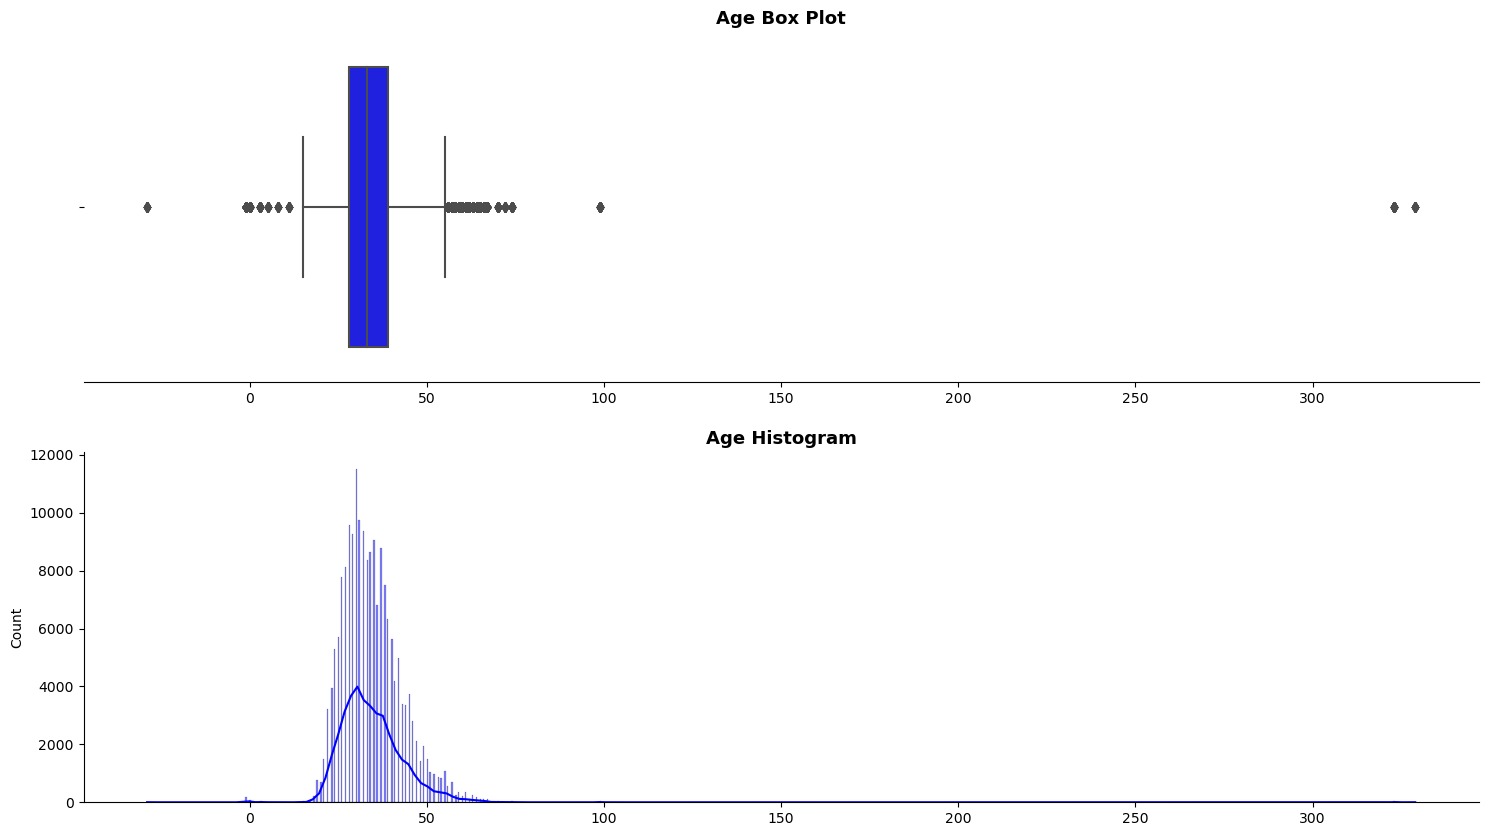

In [140]:
outlier_plot(mental_health_df, 'age', box_title='Age Box Plot', hist_title='Age Histogram', xlabel=None, ylabel=None)

> It seems that two of the rows are unusually high and some of the rows are unusually low, possibly joke answers. I'll delete those rows (since there are so few in the dataset) re-evaluate. Seeing as this survey is intended for working individuals in the tech field, I'll set the lower threshold to 18. 

In [144]:
lower_age_threshold = 18
upper_age_threshold = 100

original_row_count = len(mental_health_df)
mental_health_df = mental_health_df[(mental_health_df['age'] >= lower_age_threshold) & (mental_health_df['age'] <= upper_age_threshold)]

new_row_count = len(mental_health_df)
removed_rows = original_row_count - new_row_count
unique_ages_after_removal = mental_health_df['age'].unique()

removed_rows, unique_ages_after_removal

(496,
 array([37, 44, 32, 31, 33, 35, 39, 42, 23, 29, 36, 27, 46, 41, 34, 30, 40,
        38, 50, 24, 18, 28, 26, 22, 19, 25, 45, 21, 43, 56, 60, 54, 55, 48,
        20, 57, 58, 47, 62, 51, 65, 49, 53, 61, 72, 52, 63, 99, 66, 59, 74,
        70, 64, 67], dtype=int64))

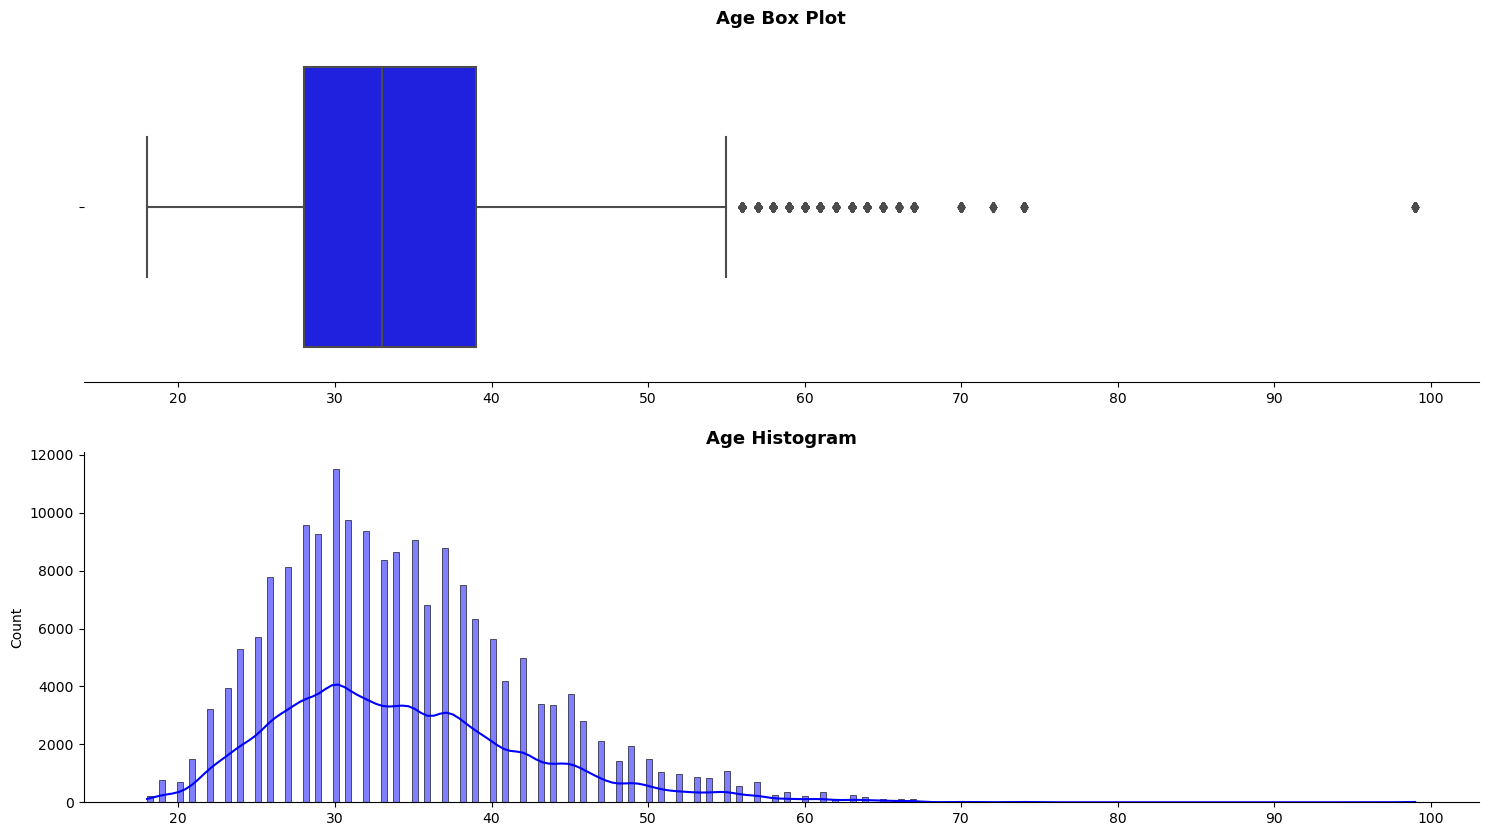

In [145]:
outlier_plot(mental_health_df, 'age', box_title='Age Box Plot', hist_title='Age Histogram', xlabel=None, ylabel=None)

> I'm comfortable having removed 496 rows seeing as the scope of the survey is working individuals. The age values are now more concentrated, ranging approximately from 18 to 65, which is a more typical working age range. There are still a few potential outliers on the higher end, around ages 70 to 99, but these are not as extreme as the values we removed earlier. The distribution is right-skewed, meaning that there are more younger individuals in the dataset compared to older individuals.

> Given that I made these changes, I'm going to export and reimport the dataset to ensure I can continue from where I left off.  

In [146]:
mental_health_df.to_csv(r'mental_health_clean_v2.csv', index=False, header=True)

In [147]:
mental_health_df = pd.read_csv('mental_health_clean_v2.csv')

## Creating Graph Functions

In [148]:
def create_plot(data, x_col, y_col, plot_type, title, x_label, y_label, hue=None):
    plt.figure(figsize=(10, 6))
    
    if plot_type == 'scatter':
        ax = sns.scatterplot(x=x_col, y=y_col, data=data, hue=hue)
    elif plot_type == 'bar':
        ax = sns.barplot(x=x_col, y=y_col, data=data, hue=hue)
        plt.xticks(rotation=90)
    elif plot_type == 'box':
        ax = sns.boxplot(x=x_col, y=y_col, data=data, hue=hue)
        plt.xticks(rotation=90)
    elif plot_type == 'hist':
        ax = sns.histplot(data=data[x_col], kde=True, hue=hue)
    elif plot_type == 'violin':
        ax = sns.violinplot(x=x_col, y=y_col, data=data, hue=hue)
        plt.xticks(rotation=90)
    elif plot_type == 'count':
        ax = sns.countplot(x=x_col, data=data, hue=hue, order=data[x_col].value_counts().index)
        plt.xticks(rotation=90)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(title=hue, loc='upper right') if hue else None
    plt.show()

## Univariate

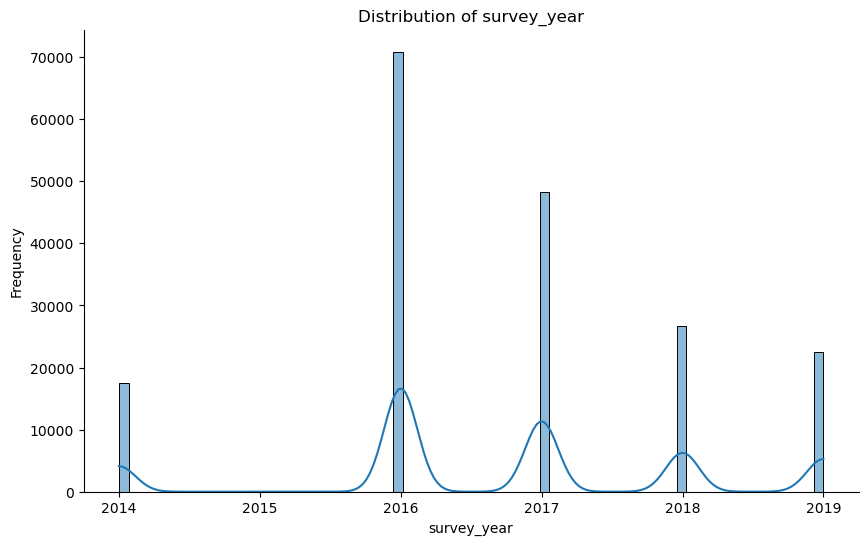

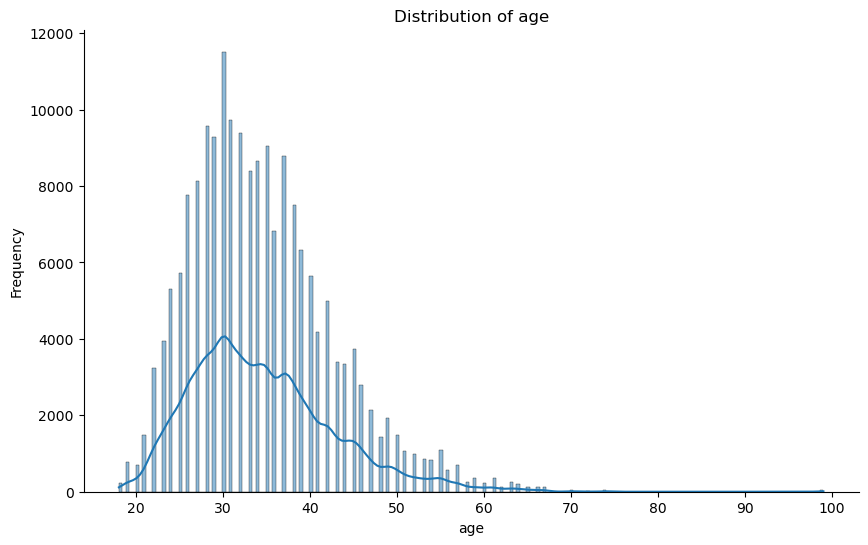

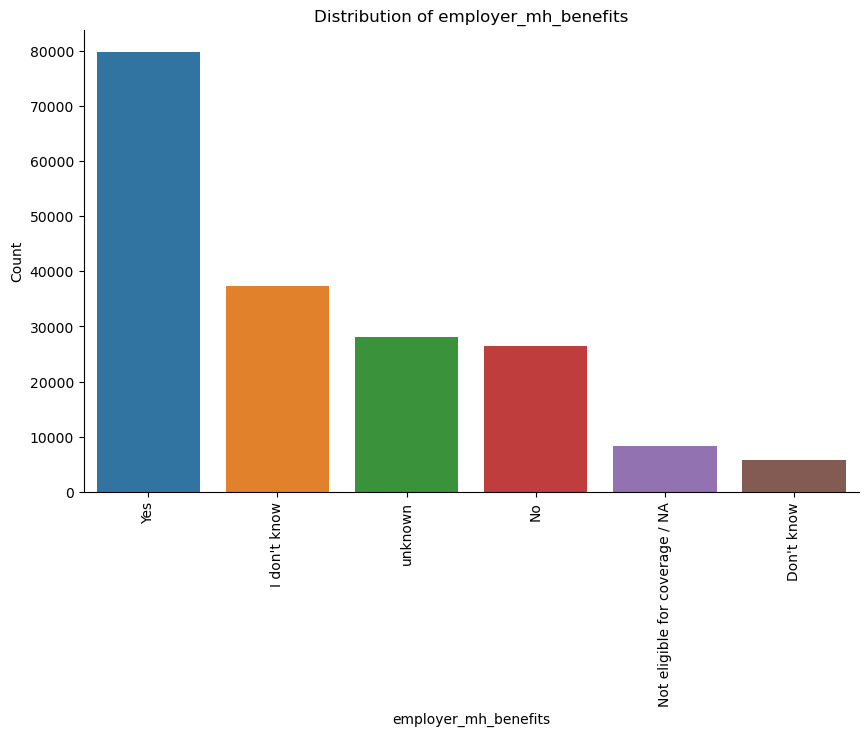

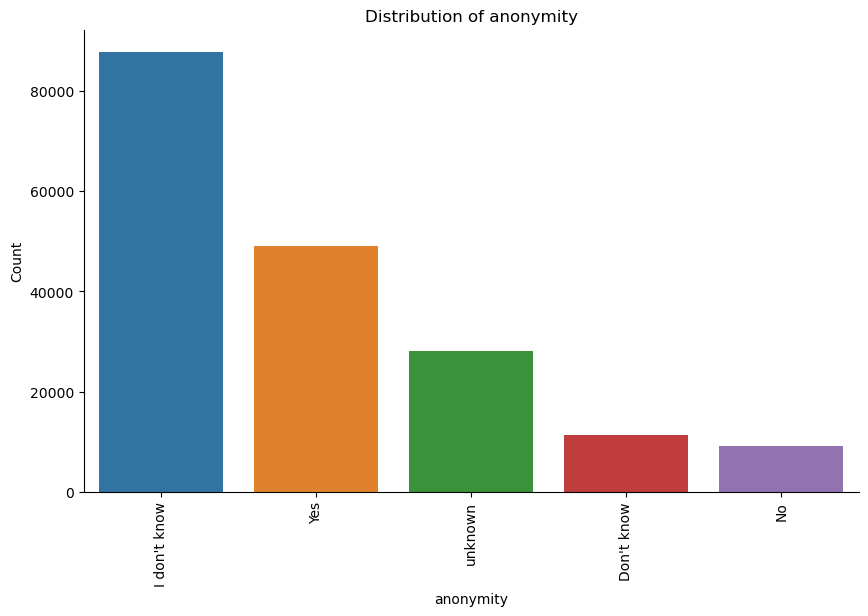

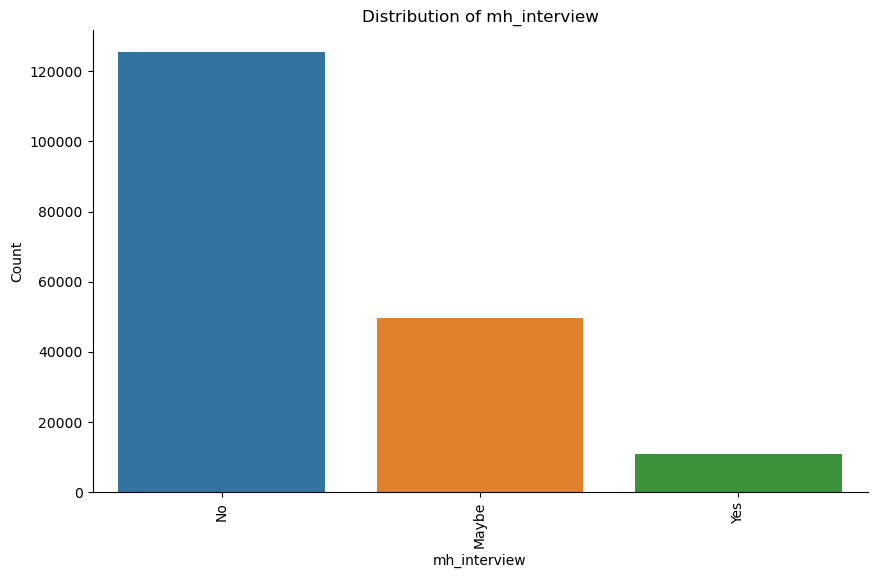

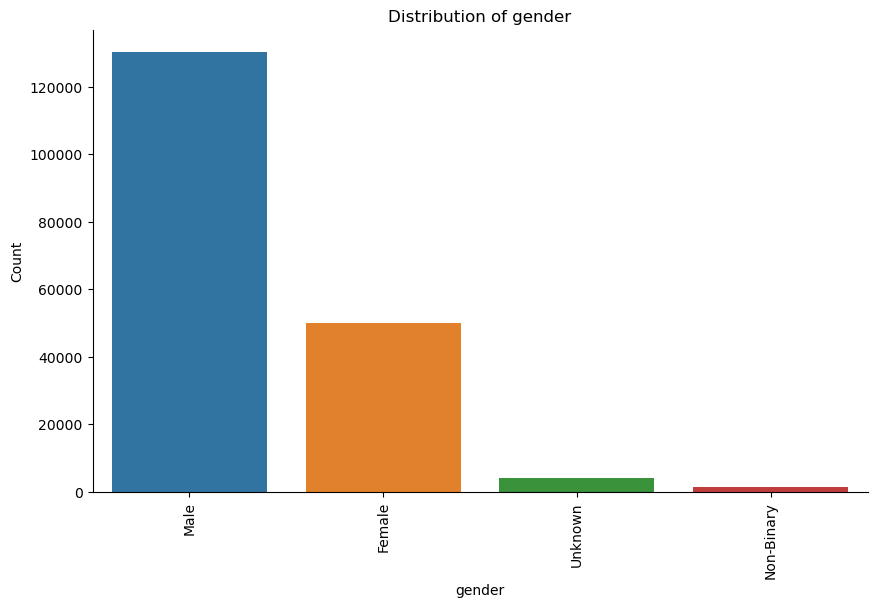

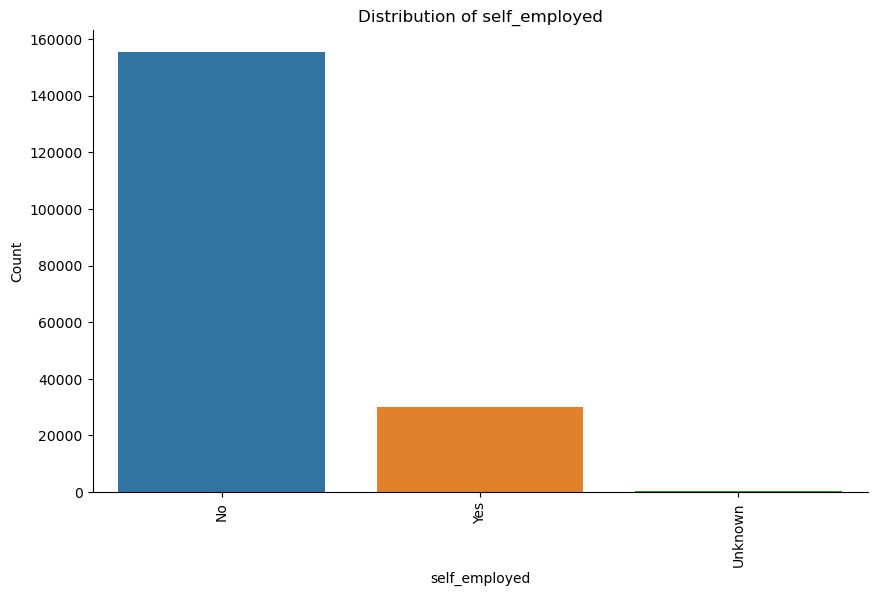

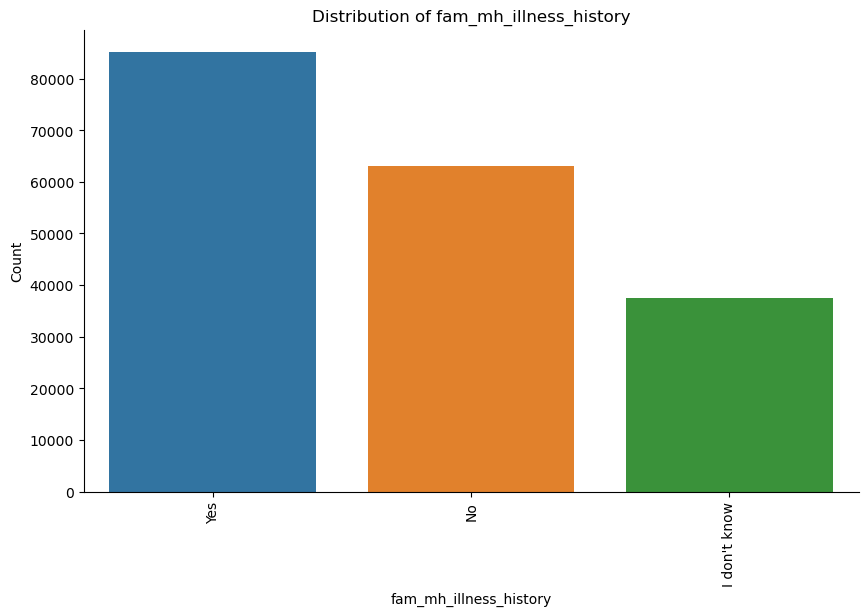

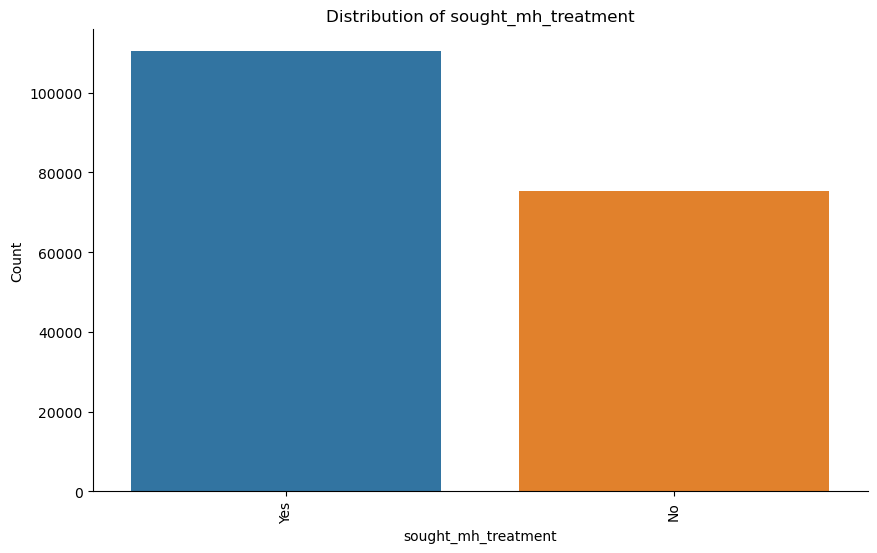

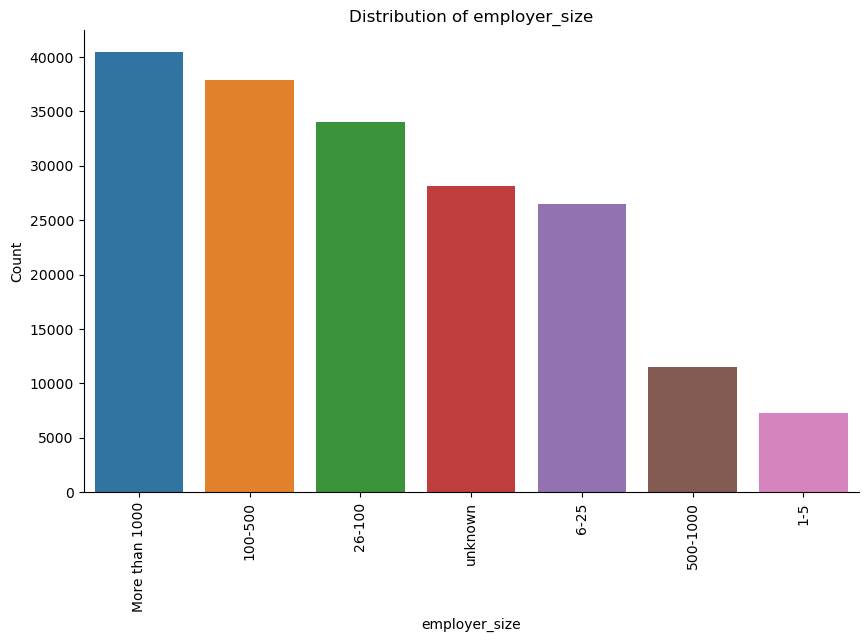

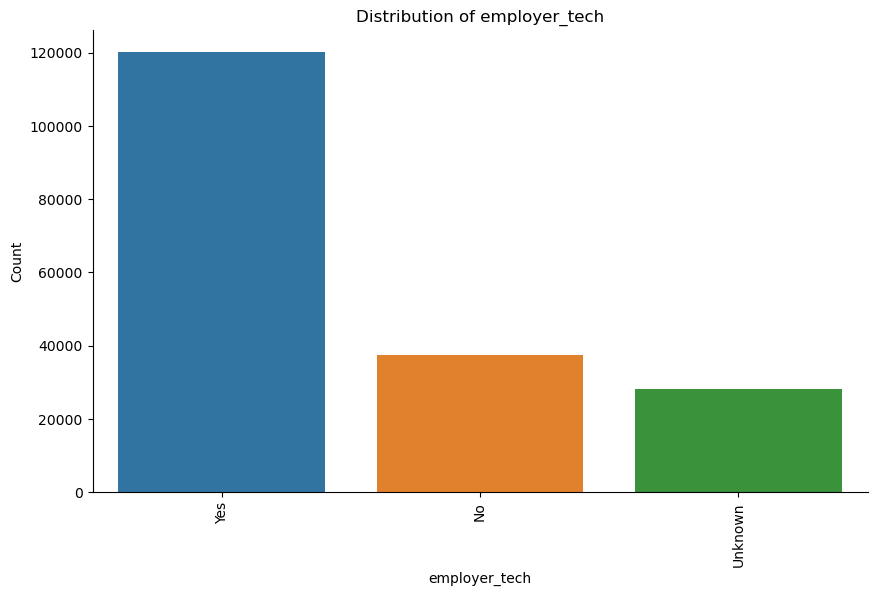

In [150]:
columns_to_skip = ['answer', 'user_id', 'question', 'country', 'us_state']

for column in mental_health_df.columns:
    if column not in columns_to_skip:
        col_type = mental_health_df[column].dtype

        title = f"Distribution of {column}"
        x_label = column
        y_label = 'Frequency' if col_type != 'object' else 'Count'

        if col_type == 'object':
            create_plot(mental_health_df, column, None, 'count', title, x_label, y_label)
        else:
            create_plot(mental_health_df, column, None, 'hist', title, x_label, y_label)

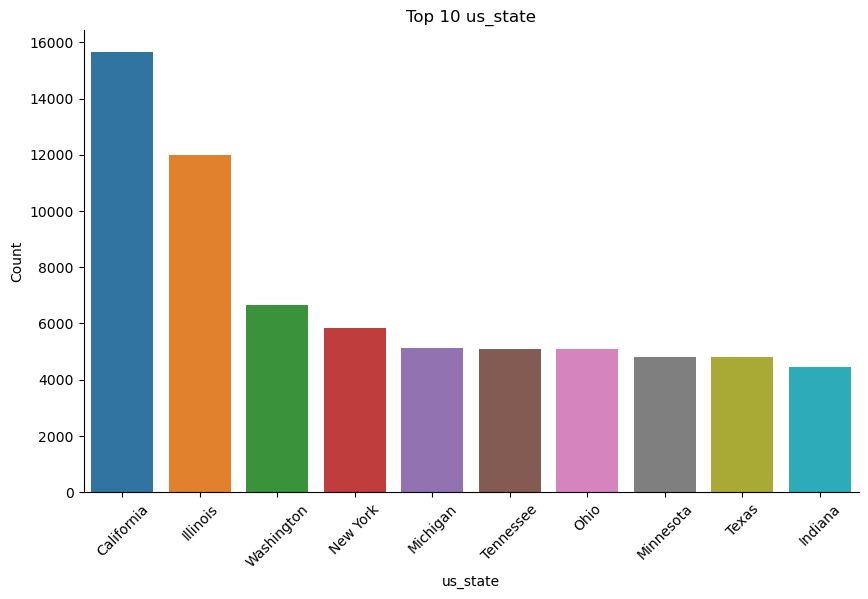

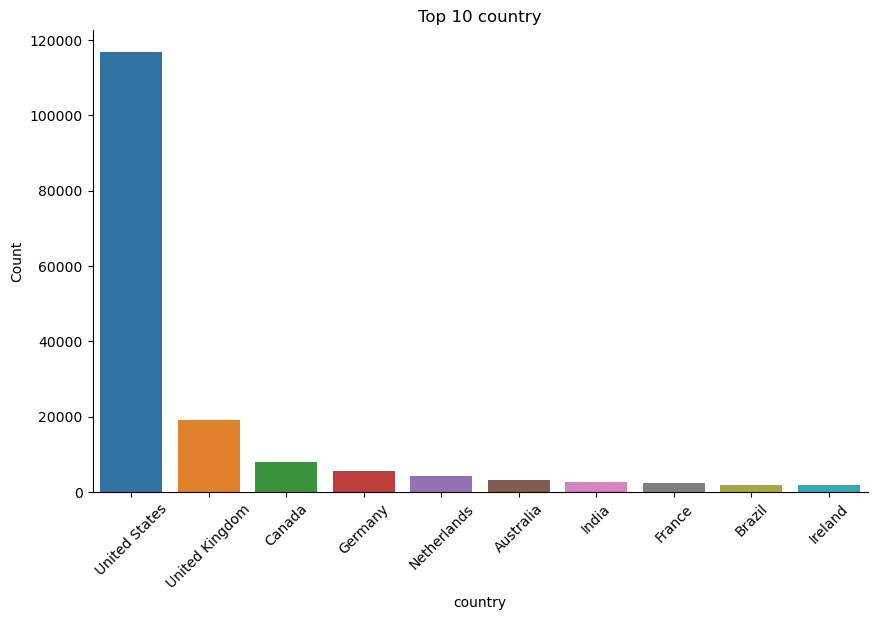

In [152]:
def plot_top_categories_corrected(data, column):
    top_categories = data[column].value_counts().head(10)
    
    title = f"Top 10 {column}"
    x_label = column
    y_label = 'Count'

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.tick_params(axis='x', rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

plot_top_categories_corrected(mental_health_df, 'us_state')
plot_top_categories_corrected(mental_health_df, 'country')

### Univariate Insights 

- Age: The majority of respondents are in their late 20s to early 30s. The distribution is slightly right-skewed, indicating a younger demographic.
- Gender: There are more male respondents than female or non-binary respondents.
- Country: The majority of respondents are from the United States, followed by the United Kingdom and Canada.
- US State: The distribution is spread across different states, with California having the highest number of respondents.
- survey_year: The majority of responses are from the year 2018.
- employer_mh_benefits: Most respondents are unsure about their employer's mental health benefits.
- anonymity: A significant number of respondents don't know if their anonymity is protected when seeking mental health treatment through their employer.
- mh_interview: Most respondents are possibly hesitant or unwilling to discuss mental health during a job interview.
- gender: The dataset is predominantly comprised of male and female respondents.
- country: The United States has the highest number of responses, followed by the United Kingdom and Canada.
- us_state: California, Illinois, and Washington have the highest number of responses among U.S. states.
- self_employed: The majority of respondents are not self-employed.
- fam_mh_illness_history: The responses are fairly evenly distributed between respondents with a family history of mental illness and those without.
- sought_mh_treatment: A significant number of respondents have sought treatment for a mental health condition.
- employer_size: The responses are spread across different employer sizes, with the '26-100' category being the most common.
- employer_tech: The majority of respondents work in the tech industry.


## Bivariate

### Age and Seeking Mental Health Treatment: 
Is there a particular age group that is more likely to seek treatment for mental health conditions?

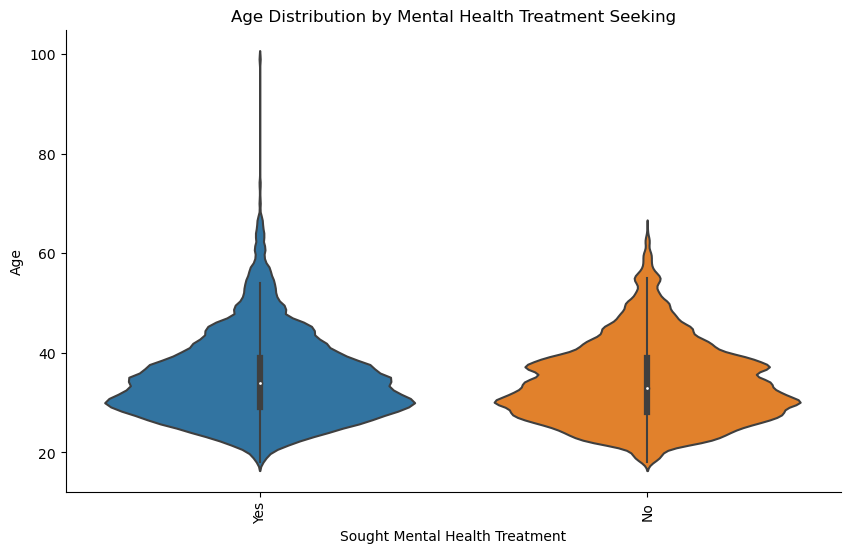

In [153]:
create_plot(
    data=mental_health_df,
    x_col='sought_mh_treatment',
    y_col='age',
    plot_type='violin',
    title='Age Distribution by Mental Health Treatment Seeking',
    x_label='Sought Mental Health Treatment',
    y_label='Age',
    hue=None
)

> The age distribution of individuals who have sought mental health treatment appears to be slightly younger compared to those who haven't.

> Both groups have a similar shape in their distribution, with the majority of respondents being in their 20s and 30s.

> There are a few older individuals who have sought mental health treatment, as indicated by the longer tail on the right side of the “Yes” category.

> This suggests that younger individuals might be more open to or in need of seeking mental health treatment, but the difference is not extremely pronounced.

### Gender and Family Mental Health History: 
Is there a gender difference in the prevalence of family mental health illness history?

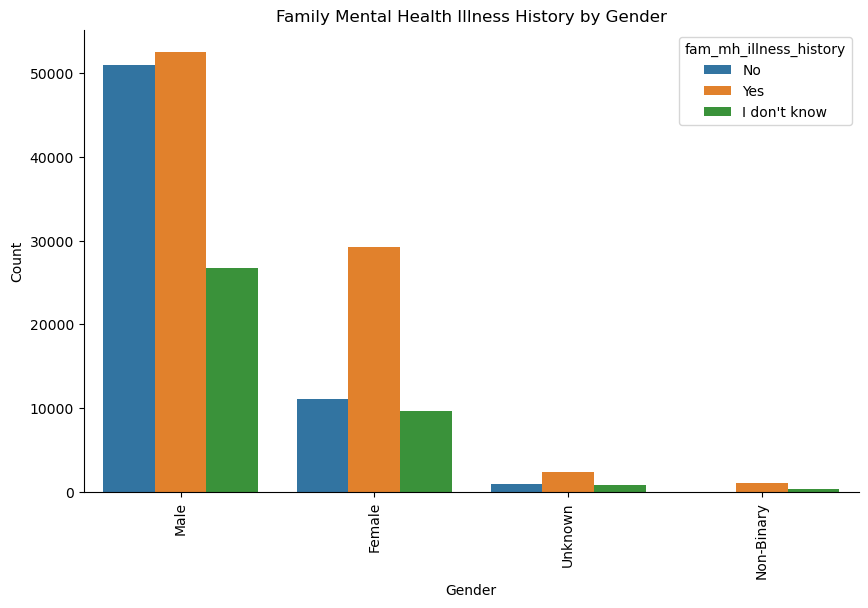

In [155]:
create_plot(
    data=mental_health_df,
    x_col='gender',
    y_col='fam_mh_illness_history',
    plot_type='count',
    title='Family Mental Health Illness History by Gender',
    x_label='Gender',
    y_label='Count',
    hue='fam_mh_illness_history'
)

> The distribution of family mental health illness history is fairly similar across different gender categories.

> Both male and female respondents show a balanced distribution between having a family history of mental health illness and not having one.

> The “Other” gender category also follows a similar trend, though the counts are significantly lower due to fewer respondents in this category.

> This suggests that the prevalence of family mental health illness history does not significantly vary by gender in this dataset.

### Employer Size and Mental Health Interview: 
Does the size of the employer influence an employee’s willingness to discuss mental health during a job interview?

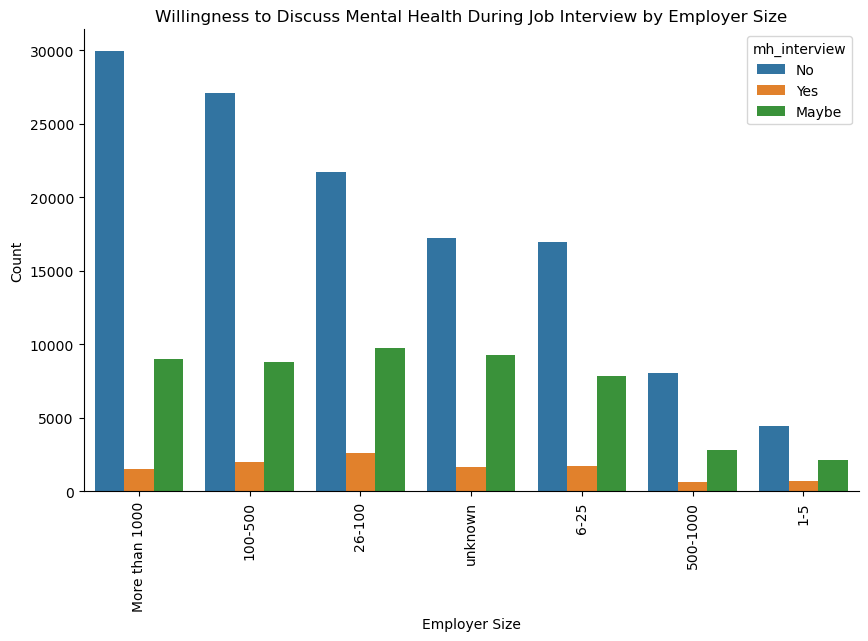

In [156]:
create_plot(
    data=mental_health_df,
    x_col='employer_size',
    y_col='mh_interview',
    plot_type='count',
    title='Willingness to Discuss Mental Health During Job Interview by Employer Size',
    x_label='Employer Size',
    y_label='Count',
    hue='mh_interview'
)

> Across different employer sizes, a majority of respondents are hesitant to discuss mental health during a job interview, indicating a potential fear of stigma or negative repercussions.

> The distribution of responses is fairly consistent across employer sizes, suggesting that the size of the employer does not significantly influence an individual’s willingness to discuss mental health during an interview.

> There is a notable number of respondents across all employer sizes who are willing to discuss mental health depending on the circumstances.

> This highlights the need for creating a supportive and open work environment where mental health can be discussed freely, regardless of the employer's size.

### Tech Industry and Mental Health Treatment: 
Are individuals in the tech industry more likely to seek treatment for mental health conditions compared to those in non-tech industries?

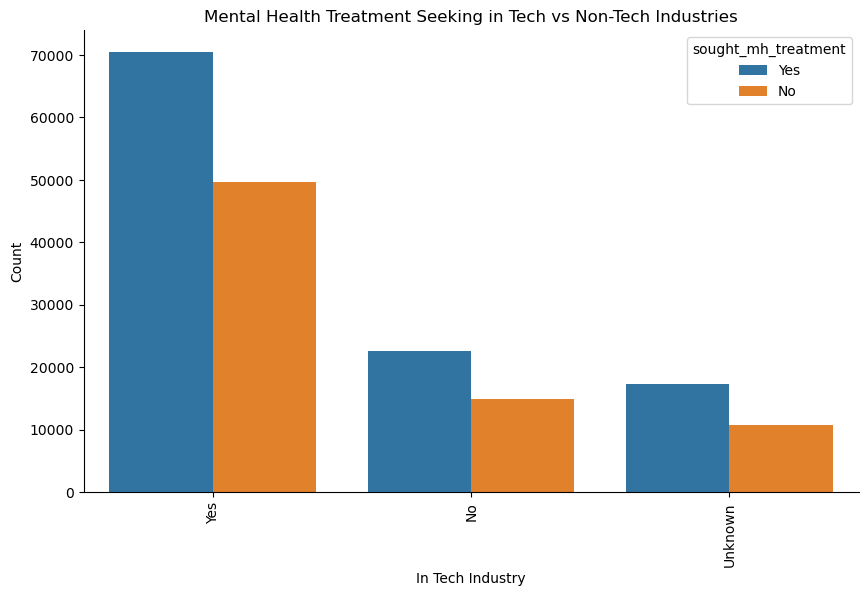

In [157]:
create_plot(
    data=mental_health_df,
    x_col='employer_tech',
    y_col='sought_mh_treatment',
    plot_type='count',
    title='Mental Health Treatment Seeking in Tech vs Non-Tech Industries',
    x_label='In Tech Industry',
    y_label='Count',
    hue='sought_mh_treatment'
)

> The distribution of mental health treatment seeking is fairly similar between individuals in the tech industry and those in non-tech industries.

> In both categories, a significant number of respondents have sought treatment for a mental health condition.

> This suggests that the industry type (tech vs non-tech) does not play a major role in an individual's likelihood to seek mental health treatment within this dataset.

### Self-Employment and Awareness of Mental Health Benefits: 
Are self-employed individuals less aware of mental health benefits compared to those who are not self-employed?

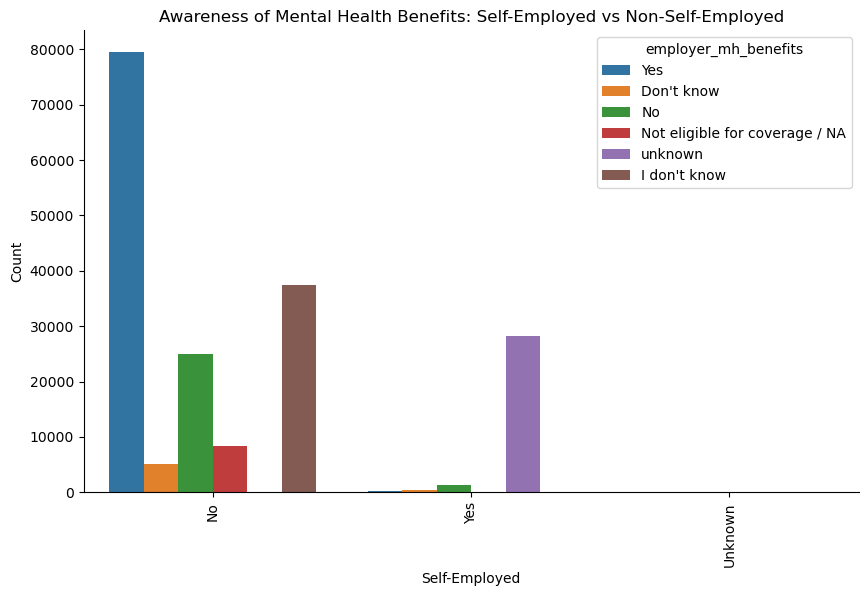

In [158]:
create_plot(
    data=mental_health_df,
    x_col='self_employed',
    y_col='employer_mh_benefits',
    plot_type='count',
    title='Awareness of Mental Health Benefits: Self-Employed vs Non-Self-Employed',
    x_label='Self-Employed',
    y_label='Count',
    hue='employer_mh_benefits'
)

> A significant portion of self-employed individuals are unsure about mental health benefits, which is expected since they might not have an employer providing these benefits.

> Among non-self-employed individuals, the responses are fairly distributed across different levels of awareness regarding employer mental health benefits.

> A noticeable number of non-self-employed individuals are aware that their employer provides mental health benefits.

> This highlights a clear distinction in awareness based on employment status, with self-employed individuals being less likely to have access to or be aware of employer-provided mental health benefits.

### Age and Gender: 
What is the age distribution across different genders?

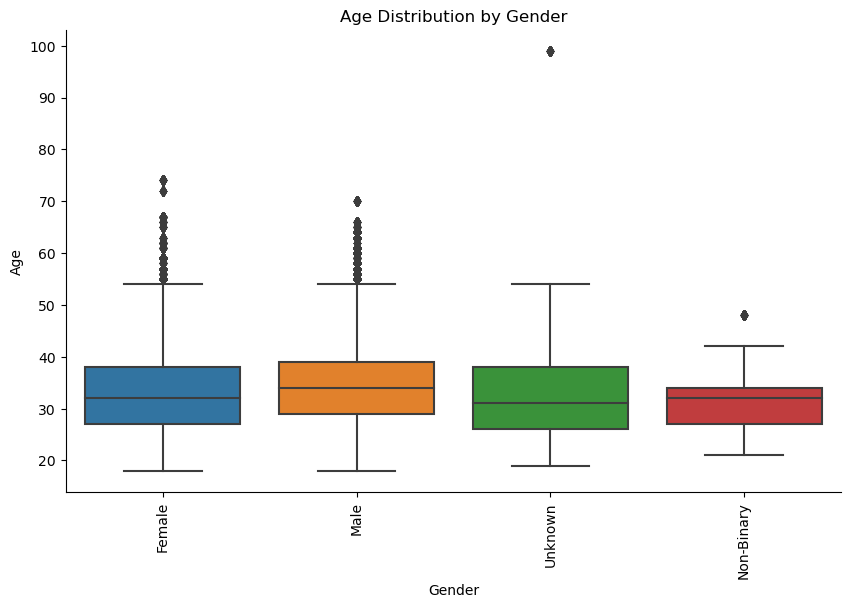

In [159]:
create_plot(
    data=mental_health_df,
    x_col='gender',
    y_col='age',
    plot_type='box',
    title='Age Distribution by Gender',
    x_label='Gender',
    y_label='Age',
    hue=None
)

> The age distribution across different genders is fairly consistent, with the median age being around 30 for both male and female respondents.

> The interquartile range (IQR), representing the middle 50% of ages, is slightly wider for females, indicating more variability in ages.

> There are some outliers in both the male and female categories, particularly in the older age range.

> The "Other" gender category has a wider range of ages, but this could be influenced by the lower number of respondents in this category.

> Overall, there are no major differences in age distribution across genders within this dataset.

### U.S. State and Seeking Mental Health Treatment: 
Are there specific U.S. states where individuals are more likely to seek treatment for mental health conditions?

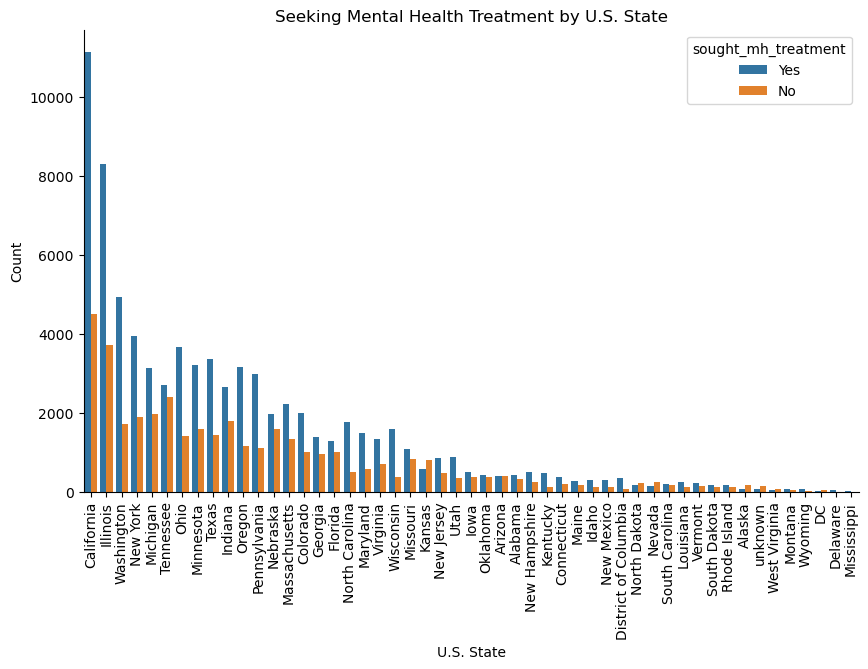

In [161]:
create_plot(
    data=mental_health_df,
    x_col='us_state',
    y_col='sought_mh_treatment',
    plot_type='count',
    title='Seeking Mental Health Treatment by U.S. State',
    x_label='U.S. State',
    y_label='Count',
    hue='sought_mh_treatment'
)

> Across different U.S. states, a considerable number of respondents have sought treatment for a mental health condition.

> States like California, Washington, and New York have higher counts of individuals seeking mental health treatment, which could be influenced by a larger population size and potentially more awareness or availability of mental health resources.

> The distribution between those who have and haven't sought treatment is fairly consistent across states, suggesting that state-specific factors might not play a major role in an individual's likelihood to seek mental health treatment within this dataset.

> However, it's important to consider other factors such as population size, urbanization, and availability of mental health services when interpreting these results.

### Employer Size and Awareness of Mental Health Benefits
How does awareness of employer-provided mental health benefits vary across different employer sizes?

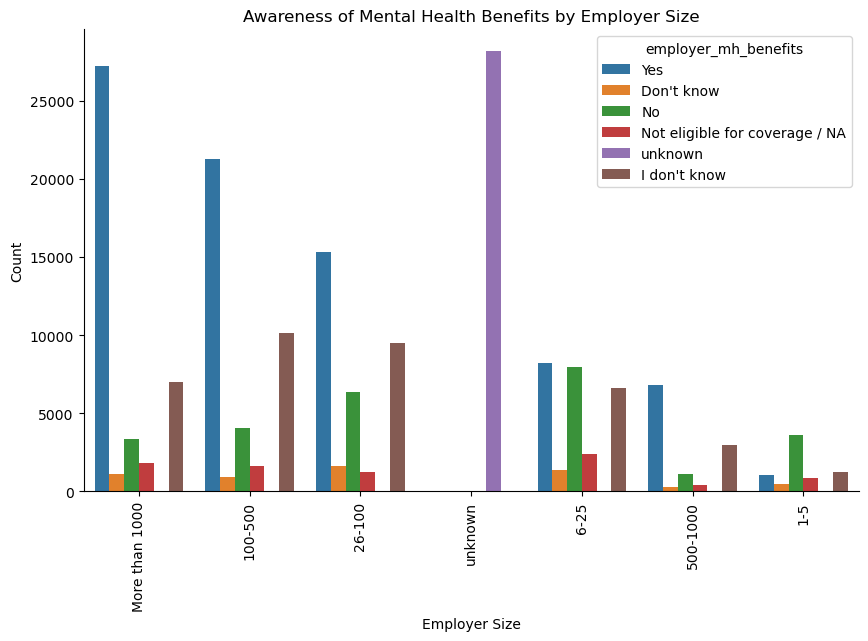

In [162]:
create_plot(
    data=mental_health_df,
    x_col='employer_size',
    y_col='employer_mh_benefits',
    plot_type='count',
    title='Awareness of Mental Health Benefits by Employer Size',
    x_label='Employer Size',
    y_label='Count',
    hue='employer_mh_benefits'
)

> Across different employer sizes, a significant number of respondents are unsure about their employer's mental health benefits.

> In smaller companies (1-5, 6-25 employees), there seems to be less awareness, with a higher proportion of respondents being unsure or stating that their employer does not provide mental health benefits.

> As the company size increases, there is a noticeable increase in the proportion of respondents who are aware of their employer providing mental health benefits, particularly in companies with more than 100 employees.

> This suggests that larger companies may be more likely to provide mental health benefits, or at least there is a higher awareness of such benefits among their employees.

### Age and Awareness of Anonymity Protection
Is there a correlation between age and awareness of anonymity protection when seeking mental health treatment?

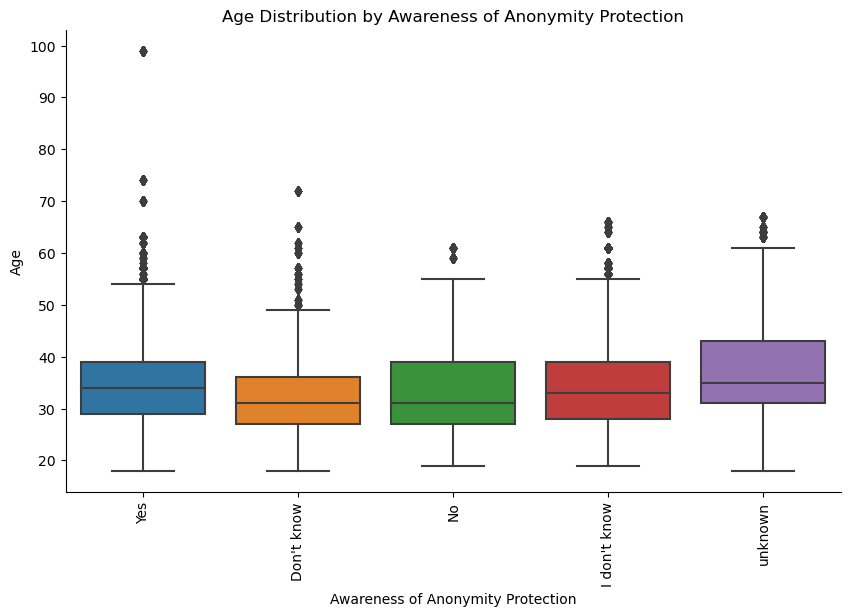

In [163]:
create_plot(
    data=mental_health_df,
    x_col='anonymity',
    y_col='age',
    plot_type='box',
    title='Age Distribution by Awareness of Anonymity Protection',
    x_label='Awareness of Anonymity Protection',
    y_label='Age',
    hue=None
)

> The age distribution across different levels of awareness regarding anonymity protection is fairly consistent, with median ages around 30-35 across all categories.

> Respondents who are aware of their anonymity being protected when seeking mental health treatment tend to have a slightly wider age range, as indicated by the larger interquartile range (IQR).

> There are outliers in all categories, particularly in the older age range.

> The age distribution of respondents who are unsure about anonymity protection is slightly narrower, indicating less variability in age.

> Overall, there doesn’t seem to be a strong correlation between age and awareness of anonymity protection based on this plot.

### Gender and Seeking Mental Health Treatment
Are there gender differences in the likelihood of seeking treatment for a mental health condition?

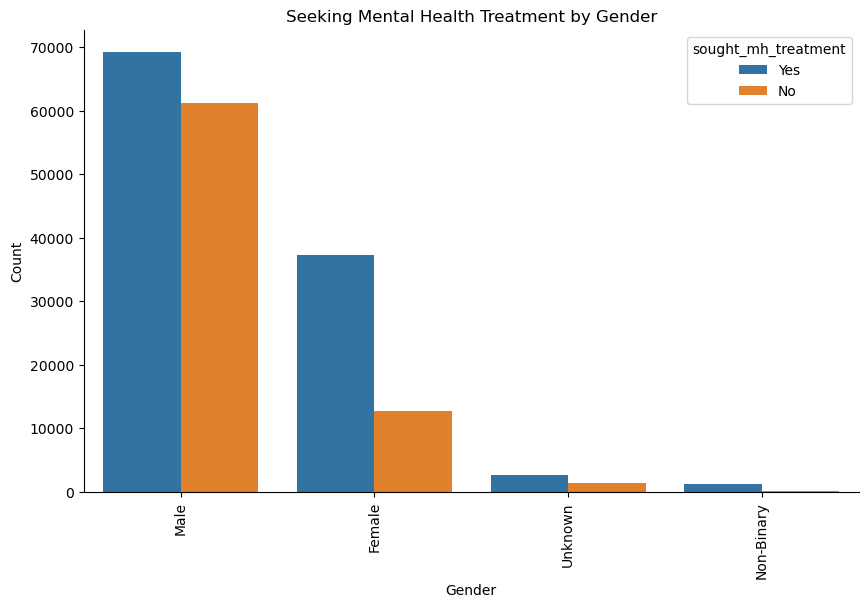

In [164]:
create_plot(
    data=mental_health_df,
    x_col='gender',
    y_col='sought_mh_treatment',
    plot_type='count',
    title='Seeking Mental Health Treatment by Gender',
    x_label='Gender',
    y_label='Count',
    hue='sought_mh_treatment'
)

> Across different genders, a considerable number of respondents have sought treatment for a mental health condition.

> The proportion of individuals who have sought treatment is slightly higher among females compared to males.

> In the "Other" gender category, the number of individuals who have and haven't sought treatment is almost equal.

> This suggests that there might be a slight gender difference in seeking mental health treatment, with females being somewhat more likely to seek treatment compared to males.

### Tech Industry and Family Mental Health History
Are individuals in the tech industry more likely to have a family history of mental health illness compared to those in non-tech industries?

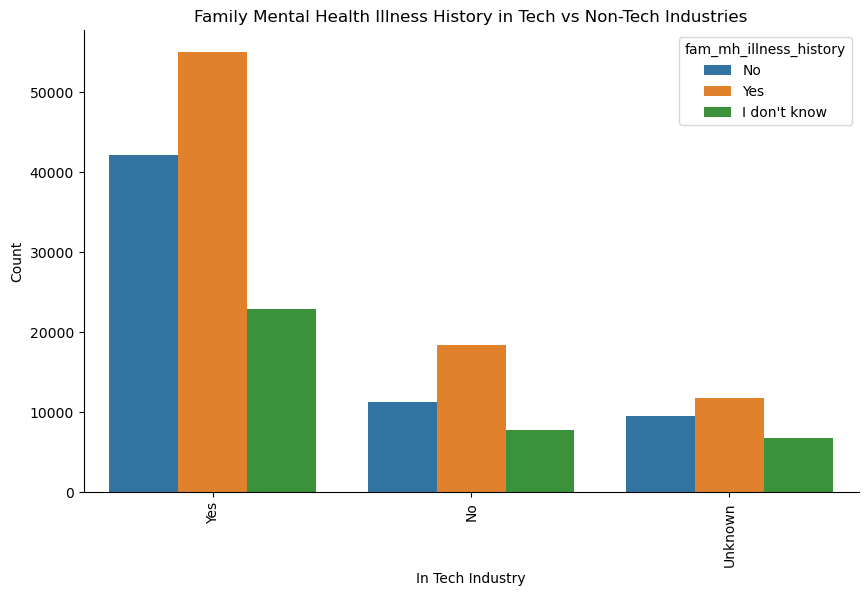

In [166]:
create_plot(
    data=mental_health_df,
    x_col='employer_tech',
    y_col='fam_mh_illness_history',
    plot_type='count',
    title='Family Mental Health Illness History in Tech vs Non-Tech Industries',
    x_label='In Tech Industry',
    y_label='Count',
    hue='fam_mh_illness_history'
)

> The distribution of family mental health illness history is fairly similar between individuals in the tech industry and those in non-tech industries.

> In both categories, a significant number of respondents have a family history of mental health illness, as well as a significant number without a family history.

> The proportions between having a family history of mental health illness and not having one are almost equal in both tech and non-tech industries.

> This suggests that the industry type (tech vs non-tech) does not play a major role in the prevalence of family mental health illness history within this dataset.

### Self-Employment and Seeking Mental Health Treatment
Are self-employed individuals less likely to seek treatment for a mental health condition?

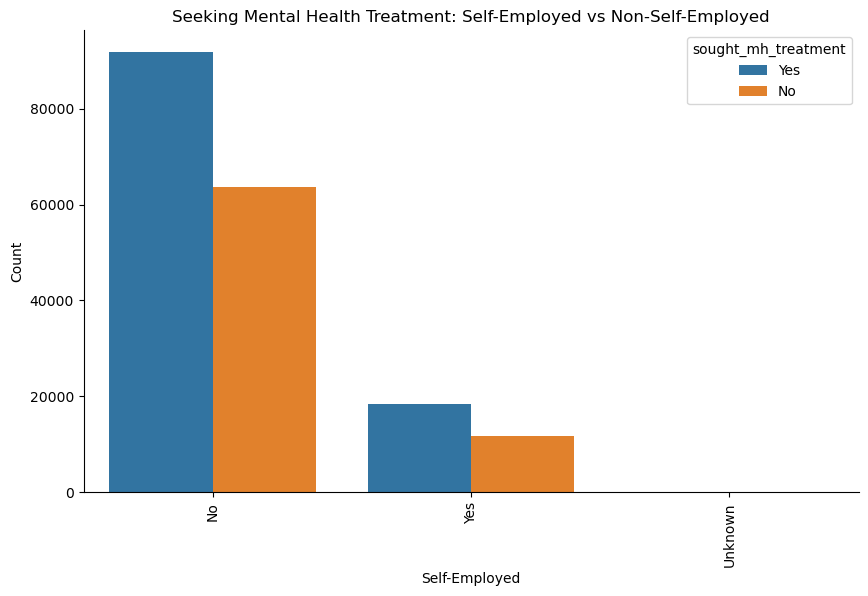

In [167]:
create_plot(
    data=mental_health_df,
    x_col='self_employed',
    y_col='sought_mh_treatment',
    plot_type='count',
    title='Seeking Mental Health Treatment: Self-Employed vs Non-Self-Employed',
    x_label='Self-Employed',
    y_label='Count',
    hue='sought_mh_treatment'
)

> The distribution of seeking mental health treatment shows some differences between self-employed and non-self-employed individuals.

> Non-self-employed individuals have a higher count of both seeking and not seeking mental health treatment, which could be due to a larger sample size in this category.

> A higher proportion of self-employed individuals have not sought mental health treatment compared to those who have. This contrast is less pronounced in non-self-employed individuals.

> This suggests that self-employed individuals might be less likely to seek mental health treatment, though further analysis would be needed to understand the underlying reasons.

### Employer Size and Family Mental Health History
How does the prevalence of family mental health illness history vary across different employer sizes?

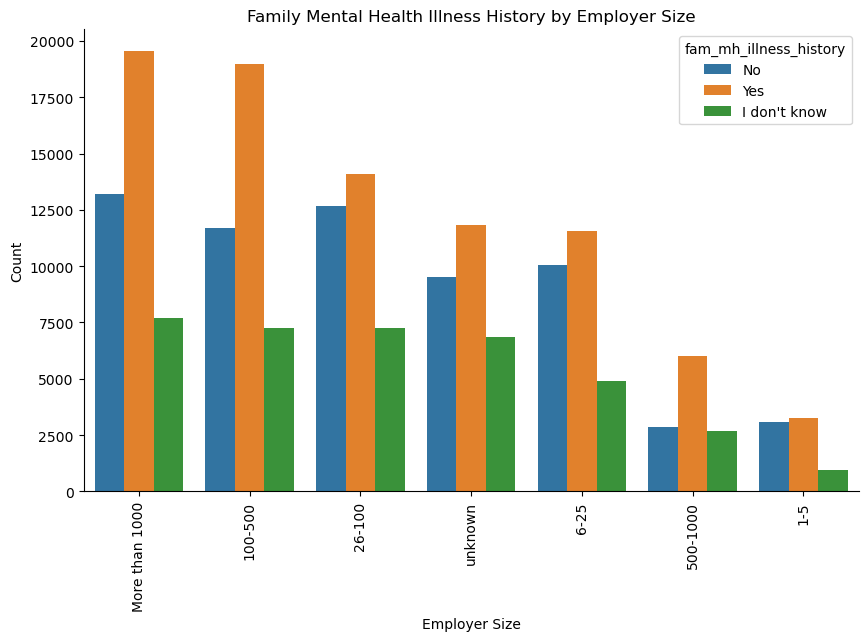

In [168]:
create_plot(
    data=mental_health_df,
    x_col='employer_size',
    y_col='fam_mh_illness_history',
    plot_type='count',
    title='Family Mental Health Illness History by Employer Size',
    x_label='Employer Size',
    y_label='Count',
    hue='fam_mh_illness_history'
)

> The distribution of family mental health illness history is fairly consistent across different employer sizes.

> In each employer size category, there is a balanced distribution between individuals with and without a family history of mental health illness.

> This suggests that the size of an individual’s employer does not have a significant impact on the prevalence of family mental health illness history within this dataset.

### Gender and Awareness of Mental Health Benefits
Are there gender differences in awareness of employer-provided mental health benefits?

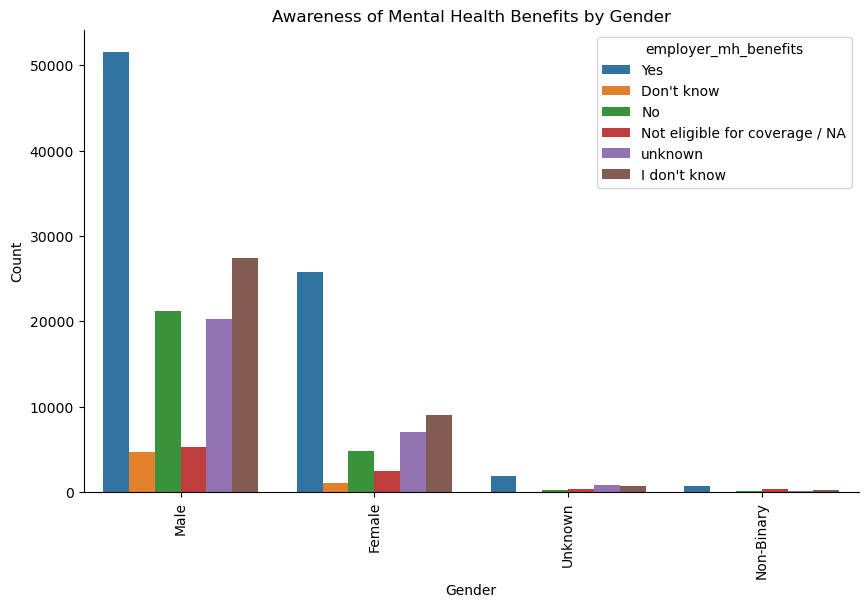

In [169]:
create_plot(
    data=mental_health_df,
    x_col='gender',
    y_col='employer_mh_benefits',
    plot_type='count',
    title='Awareness of Mental Health Benefits by Gender',
    x_label='Gender',
    y_label='Count',
    hue='employer_mh_benefits'
)

> The distribution of awareness regarding employer-provided mental health benefits is fairly similar across different genders.

> In each gender category, a significant number of respondents are unsure about their employer’s mental health benefits.

> The proportion of individuals who are aware of their employer providing mental health benefits is slightly higher in the female category compared to the male category.

> The “Other” gender category follows a similar trend, though the counts are lower due to fewer respondents in this category.

> This suggests that gender does not play a significant role in awareness of employer-provided mental health benefits within this dataset.

### Age and Self-Employment
Is there a correlation between age and the likelihood of being self-employed?

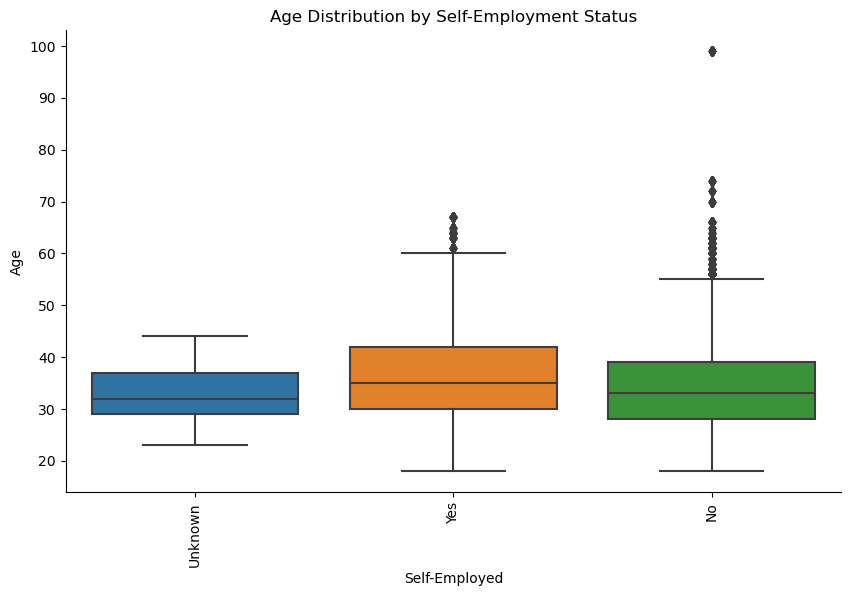

In [170]:
create_plot(
    data=mental_health_df,
    x_col='self_employed',
    y_col='age',
    plot_type='box',
    title='Age Distribution by Self-Employment Status',
    x_label='Self-Employed',
    y_label='Age',
    hue=None
)

> The age distribution between self-employed and non-self-employed individuals is fairly consistent, with median ages around 30-35 in both categories.

> The interquartile range (IQR), representing the middle 50% of ages, is slightly wider for self-employed individuals, indicating more variability in ages within this group.

> There are outliers in both categories, particularly in the older age range.

> The age distribution of self-employed individuals is slightly shifted towards older ages, suggesting that self-employment might be more common among older individuals within this dataset.

> Overall, there seems to be a slight difference in age distribution based on self-employment status, but it is not highly pronounced.

# Looking at Question & Answer Columns

> Up until now we've looked at the relationship between the 12 common questions across all years. Now let's take a look at questions that weren't included in every survey. We'll start with yes/no questions first. 

## Yes/No/Etc Questions

In [174]:
yes_no_answers = ['Yes', 'No', 'Maybe']
yes_no_data = mental_health_df[mental_health_df['answer'].isin(yes_no_answers)]

yes_no_distribution = yes_no_data.groupby(['question', 'answer']).size().reset_index(name='count')

yes_no_distribution_sorted = yes_no_distribution.sort_values(by=['question', 'answer'])

yes_no_distribution_sorted.head(10)

,question,answer,count
0,Do you believe your productivity is ever affec...,No,25
1,Do you believe your productivity is ever affec...,Yes,366
2,Do you currently have a mental health disorder?,Maybe,326
3,Do you currently have a mental health disorder?,No,965
4,Do you currently have a mental health disorder?,Yes,1235
5,Do you feel that being identified as a person ...,Maybe,585
6,Do you feel that your employer takes mental he...,No,641
7,Do you feel that your employer takes mental he...,Yes,689
8,Do you know the options for mental health care...,No,968
9,Do you know the options for mental health care...,Yes,869


In [175]:
value_counts_per_question = yes_no_data.groupby('question')['answer'].value_counts().unstack(fill_value=0)

value_counts_per_question

answer,Maybe,No,Yes
question,,,
Do you believe your productivity is ever affected by a mental health issue?,0,25,366
Do you currently have a mental health disorder?,326,965,1235
Do you feel that being identified as a person with a mental health issue would hurt your career?,585,0,0
Do you feel that your employer takes mental health as seriously as physical health?,0,641,689
Do you know the options for mental health care available under your employer-provided health coverage?,0,968,869
Do you know the options for mental health care your employer provides?,0,500,439
Do you think that discussing a mental health disorder with your employer would have negative consequences?,486,437,220
Do you think that discussing a mental health issue with your employer would have negative consequences?,476,487,289
Do you think that discussing a physical health issue with your employer would have negative consequences?,541,1755,99


Based on the value counts for the yes/no/maybe questions, we can derive the following insights:

> Mental Health in the Workplace:
- Productivity and Mental Health: A large majority of respondents believe their productivity is affected by mental health issues.
- Current Mental Health Disorder: More respondents believe they currently have a mental health disorder than those who do not, with a significant number being unsure.
- Mental vs Physical Health: Opinions are fairly divided on whether employers take mental health as seriously as physical health.
- Negative Consequences of Discussing Mental Health: More respondents think discussing mental health with their employer would not have negative consequences, but a considerable number are unsure.
- Past Mental Health Disorders: A significant number of respondents have had a mental health disorder in the past.
- Negative Consequences in the Workplace: Most respondents have not observed negative consequences for coworkers with mental health issues in their workplace.
- Unsupportive Responses in the Workplace: A majority of respondents have not observed or experienced unsupportive or badly handled responses to mental health issues in their current or previous workplace.
- Impact of Others on Willingness to Discuss Mental Health: Observations of how others are treated for discussing mental health issues have made many respondents less likely to reveal their own mental health issues in the workplace.

> Seeking Help and Comfort in Discussing Mental Health:
- Career Impact: Many respondents are unsure whether being identified as a person with a mental health issue would hurt their career.
- Perception by Team Members/Coworkers: Many respondents are unsure how their team members or coworkers would view them if they knew they suffered from a mental health issue.
- Remote Work: A significant number of respondents do not work remotely at least 50% of the time.
- Negative Impact of Revealing Mental Health Issues: Few respondents believe that revealing a mental health issue to a client, business contact, coworker, or employee has impacted them negatively.
- Anonymity in Taking Advantage of Treatment Resources: A small number of respondents had their anonymity protected when taking advantage of mental health or substance abuse treatment resources with previous employers.

> Employer Support and Resources:
- Resources for Mental Health: A significant number of respondents are unaware of the resources for mental health care provided by their employers.
- Employer Discussions on Mental Health: Less than half of the respondents have had their employer discuss mental health as part of an employee wellness program or other official communication.

> Willingness to Discuss Health Issues:
- Discussing Physical Health in Interviews: Respondents are generally unsure or unwilling to bring up a physical health issue with a potential employer in an interview.
- Discussing Mental Health with Coworkers and Supervisors: There is a slight inclination towards willingness to discuss mental health issues with coworkers and direct supervisors.
- Bringing Up Mental Health in Interviews: Respondents are generally unsure or unwilling to bring up a mental health issue with a potential employer in an interview.
- Comfort in Discussing Mental Health with Coworkers: Respondents are generally unsure or uncomfortable discussing a mental health disorder with their coworkers.
- Comfort in Discussing Physical vs Mental Health: Respondents are generally unsure or more comfortable talking to their coworkers about their physical health compared to their mental health.

### Yes/No/Etc question visualizations

### Perceived Impact of Mental Health on Productivity vs Employment Status

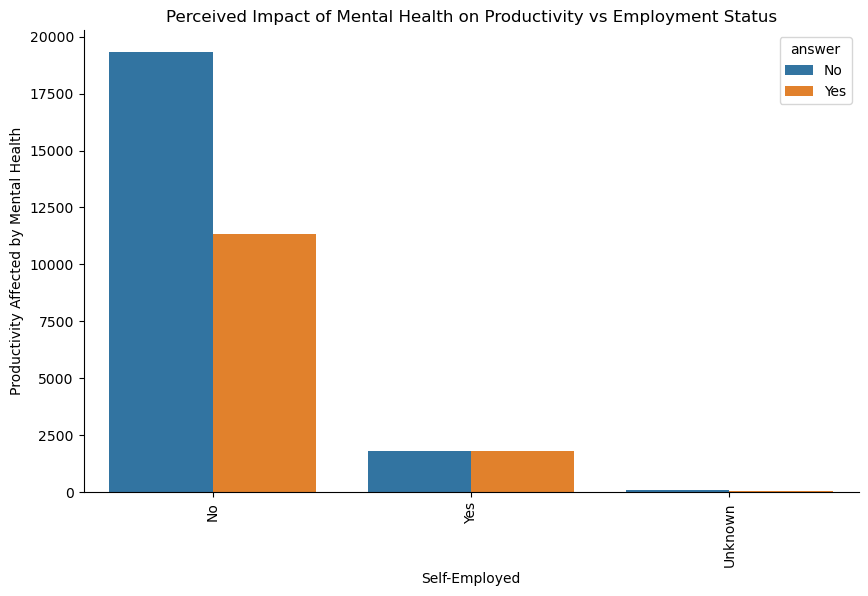

In [176]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='self_employed',
    y_col='answer',
    plot_type='count',
    title='Perceived Impact of Mental Health on Productivity vs Employment Status',
    x_label='Self-Employed',
    y_label='Productivity Affected by Mental Health',
    hue='answer'
)

- Among both self-employed and non-self-employed individuals, the majority believe that their productivity is affected by mental health issues.
- The proportion of individuals who believe their productivity is affected by mental health issues is higher among non-self-employed individuals compared to self-employed individuals.
- A small number of non-self-employed individuals do not believe that their productivity is affected by mental health issues, whereas this group is almost nonexistent among self-employed individuals.

> This suggests that perceptions of the impact of mental health on productivity are prevalent across different employment statuses, but the awareness or acknowledgment of this impact might be slightly higher among those who are not self-employed.

### Current Mental Health Disorder vs Age

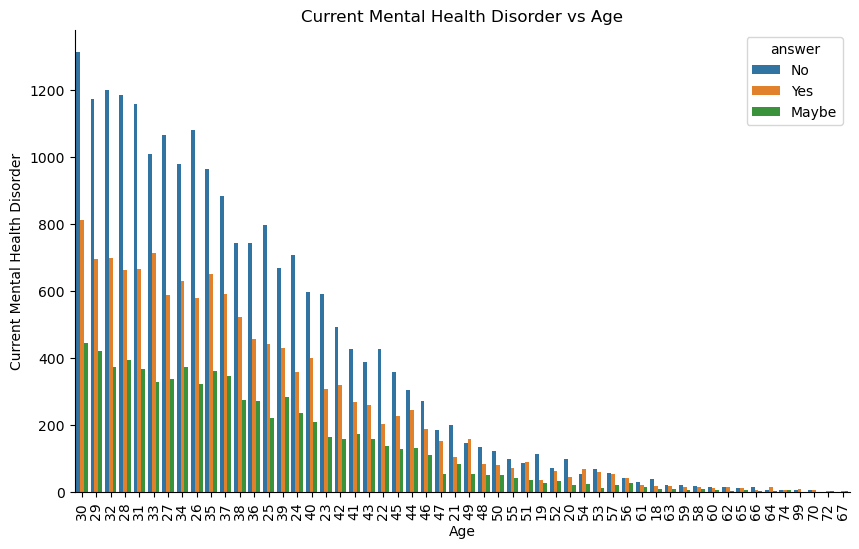

In [177]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No', 'Maybe'])],
    x_col='age',
    y_col='answer',
    plot_type='count',
    title='Current Mental Health Disorder vs Age',
    x_label='Age',
    y_label='Current Mental Health Disorder',
    hue='answer'
)

- Across different age groups, a substantial number of individuals believe they currently have a mental health disorder, with the belief being more prevalent in the younger age groups.
- The number of individuals unsure about their mental health status ("Maybe") is also noteworthy, especially in the younger age groups.
- The number of individuals who do not believe they currently have a mental health disorder tends to increase with age.
> These trends suggest that younger individuals might be more aware of or more willing to acknowledge their mental health issues, or they might actually be experiencing more mental health issues compared to older individuals. Additionally, the uncertainty around mental health status is also more prominent in younger age groups.

### Perception of Employers Taking Mental Health as Seriously as Physical Health vs Industry

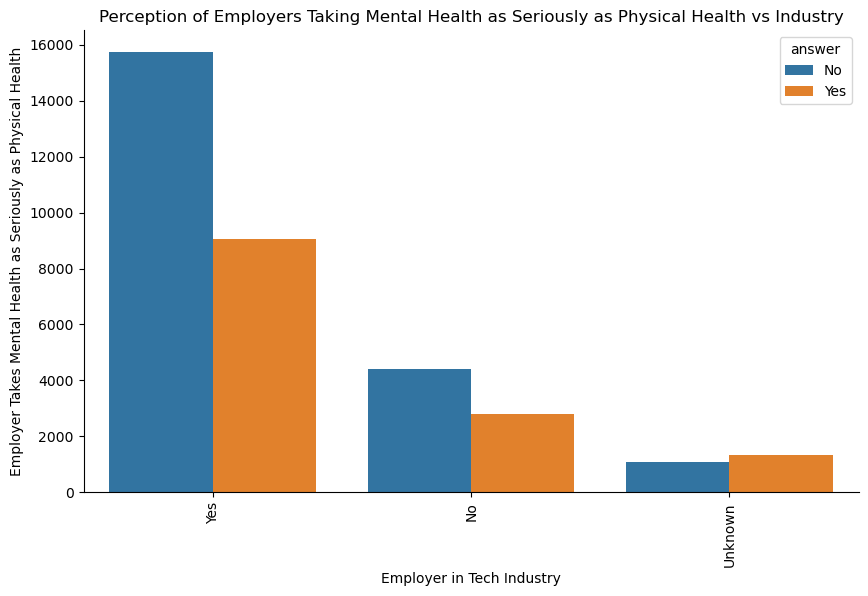

In [178]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='employer_tech',
    y_col='answer',
    plot_type='count',
    title='Perception of Employers Taking Mental Health as Seriously as Physical Health vs Industry',
    x_label='Employer in Tech Industry',
    y_label='Employer Takes Mental Health as Seriously as Physical Health',
    hue='answer'
)

- 
- In both tech and non-tech industries, opinions are divided on whether employers take mental health as seriously as physical health, with a slight tendency towards "No" in the tech industry.
- The proportion of "Yes" responses is higher in the non-tech industry compared to the tech industry, indicating that individuals in non-tech industries might perceive their employers as being more considerate of mental health issues.
- The number of "No" responses is higher in the tech industry, suggesting a perception that employers in the tech industry do not take mental health as seriously as physical health.

> These trends could reflect the high-pressure environment often associated with the tech industry, potentially leading to a perception that mental health is not given as much priority as physical health.

Perceived Negative Consequences of Discussing Mental Health vs Gender

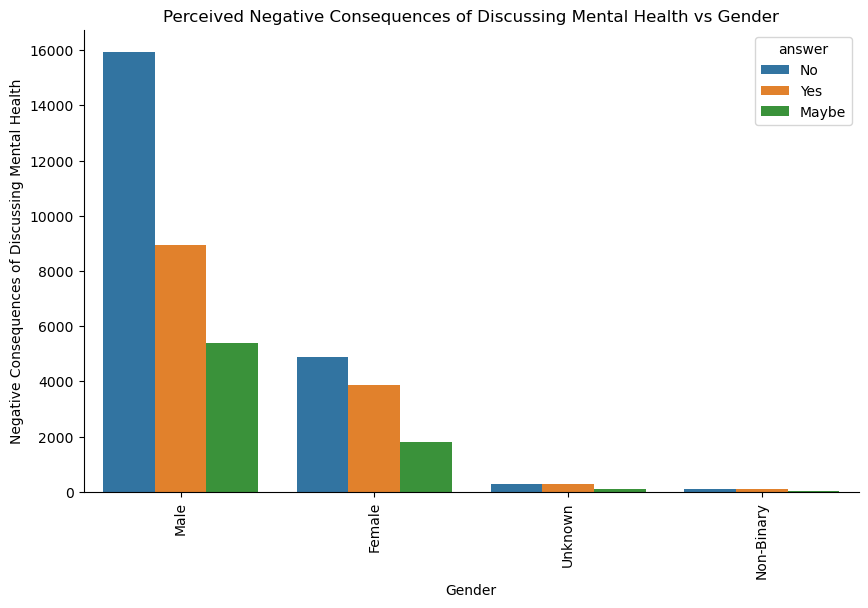

In [179]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No', 'Maybe'])],
    x_col='gender',
    y_col='answer',
    plot_type='count',
    title='Perceived Negative Consequences of Discussing Mental Health vs Gender',
    x_label='Gender',
    y_label='Negative Consequences of Discussing Mental Health',
    hue='answer'
)

- Across all genders, a significant number of individuals are unsure ("Maybe") about the potential negative consequences of discussing mental health issues with their employer.
- Among those who have a clear stance, the majority believe that discussing mental health issues with their employer would not have negative consequences, regardless of gender.
- The proportion of individuals who believe discussing mental health issues would have negative consequences is higher among males compared to females and other genders.

> These trends suggest that while uncertainty prevails across all genders regarding the potential negative consequences of discussing mental health, males are more likely to perceive potential negative consequences compared to females and other genders.

### Past Mental Health Disorders vs Country

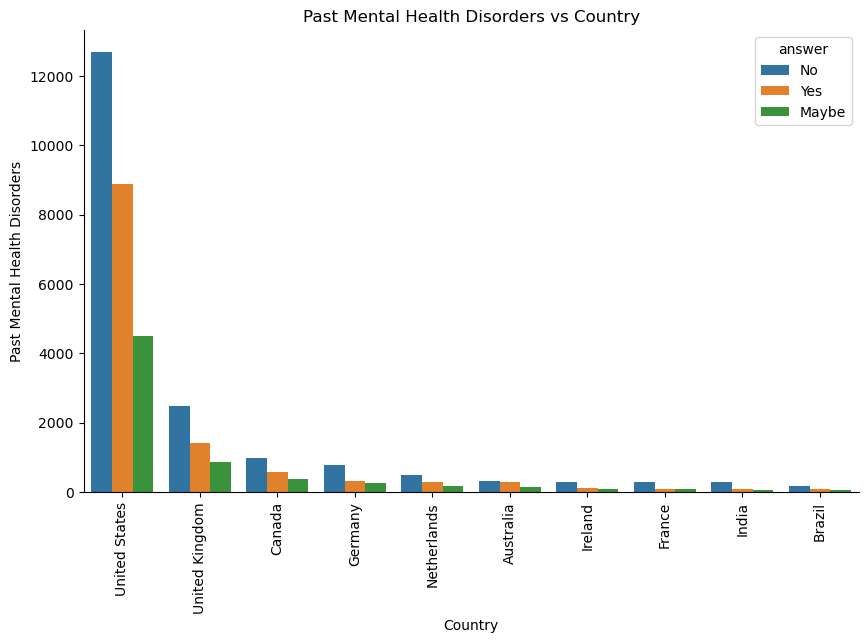

In [181]:
top_10_countries = mental_health_df['country'].value_counts().nlargest(10).index
data_filtered = mental_health_df[(mental_health_df['country'].isin(top_10_countries)) & (mental_health_df['answer'].isin(['Yes', 'No', 'Maybe']))]

create_plot(
    data=data_filtered,
    x_col='country',
    y_col='answer',
    plot_type='count',
    title='Past Mental Health Disorders vs Country',
    x_label='Country',
    y_label='Past Mental Health Disorders',
    hue='answer'
)

- The United States has the highest number of respondents who believe they have had a past mental health disorder, followed by the United Kingdom.
- In most of the top 10 countries, a significant number of individuals are unsure ("Maybe") about their past mental health status.
- The number of individuals who do not believe they have had a past mental health disorder is generally lower compared to those who believe they have, across all these countries.
- Canada and Germany have a relatively higher proportion of respondents who are unsure about their past mental health status compared to other countries.

> These trends suggest that awareness or acknowledgment of past mental health issues is relatively high in these countries, with the United States and the United Kingdom leading. However, there is still a considerable amount of uncertainty regarding past mental health status, indicating a potential area for increased awareness and support.

### Perceived Career Impact of a Mental Health Issue vs Employment Status

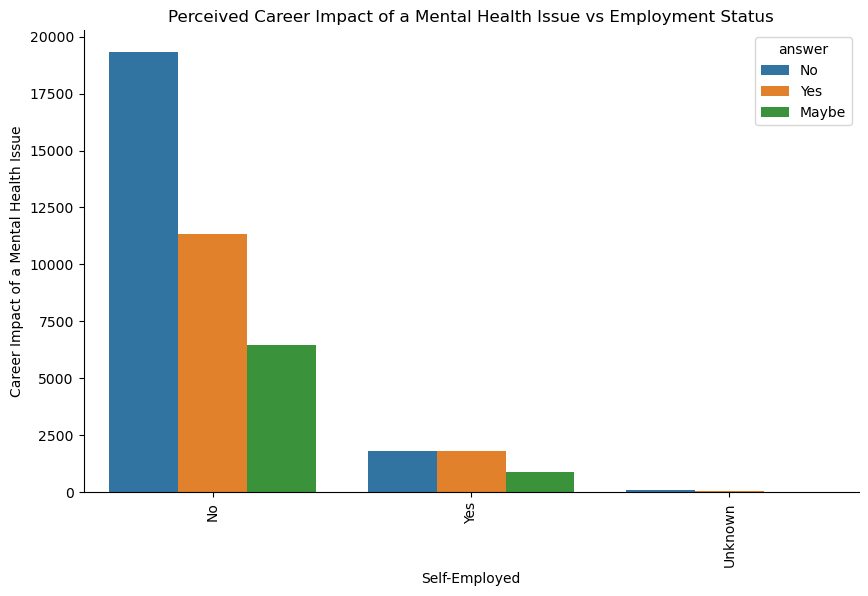

In [182]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No', 'Maybe'])],
    x_col='self_employed',
    y_col='answer',
    plot_type='count',
    title='Perceived Career Impact of a Mental Health Issue vs Employment Status',
    x_label='Self-Employed',
    y_label='Career Impact of a Mental Health Issue',
    hue='answer'
)

- A significant number of both self-employed and non-self-employed individuals are unsure ("Maybe") about the career impact of a mental health issue.
- Among those who have a clear stance, more non-self-employed individuals believe that a mental health issue would hurt their career compared to self-employed individuals.
- The number of individuals who do not believe a mental health issue would hurt their career is higher among self-employed individuals.

### Perception by Team Members/Coworkers vs Age

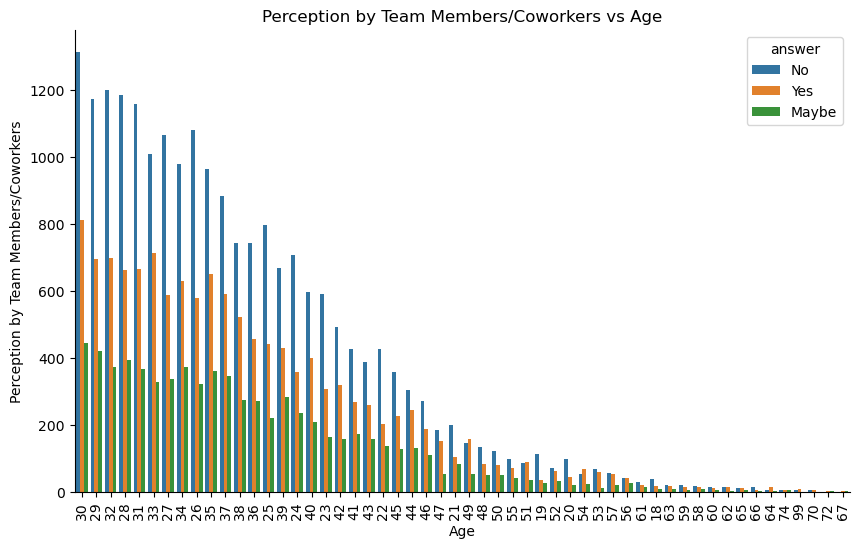

In [183]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No', 'Maybe'])],
    x_col='age',
    y_col='answer',
    plot_type='count',
    title='Perception by Team Members/Coworkers vs Age',
    x_label='Age',
    y_label='Perception by Team Members/Coworkers',
    hue='answer'
)

- Across different age groups, a considerable number of individuals are unsure about how their team members or coworkers would view them if they knew about a mental health issue.
- Younger age groups tend to have a higher proportion of individuals who believe their coworkers would view them negatively, while older age groups have a higher proportion of individuals who believe their coworkers would view them positively.

### Remote Work Prevalence vs Industry

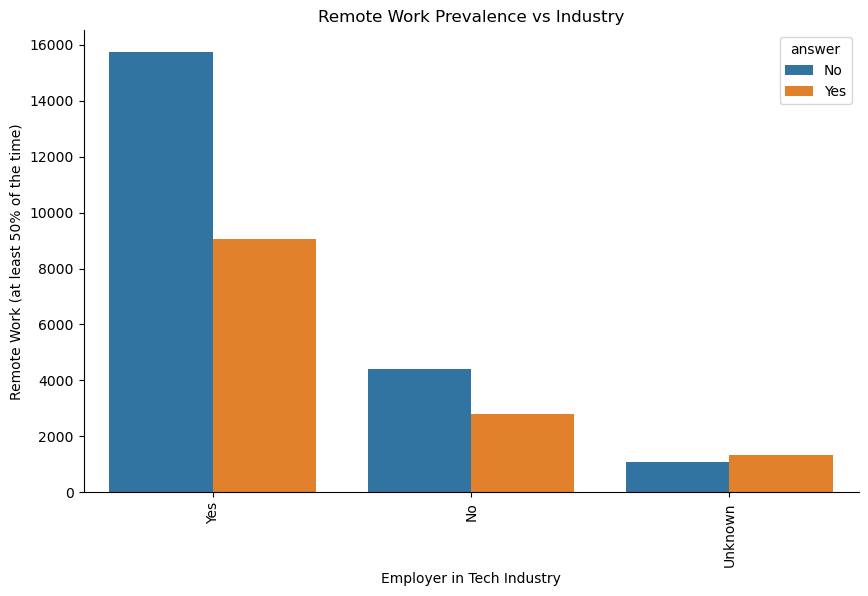

In [184]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='employer_tech',
    y_col='answer',
    plot_type='count',
    title='Remote Work Prevalence vs Industry',
    x_label='Employer in Tech Industry',
    y_label='Remote Work (at least 50% of the time)',
    hue='answer'
)

- Remote work (at least 50% of the time) is more prevalent in the tech industry compared to the non-tech industry.
- A significant number of individuals in both industries do not work remotely at least 50% of the time.

### Perceived Negative Impact of Revealing Mental Health Issues vs Gender

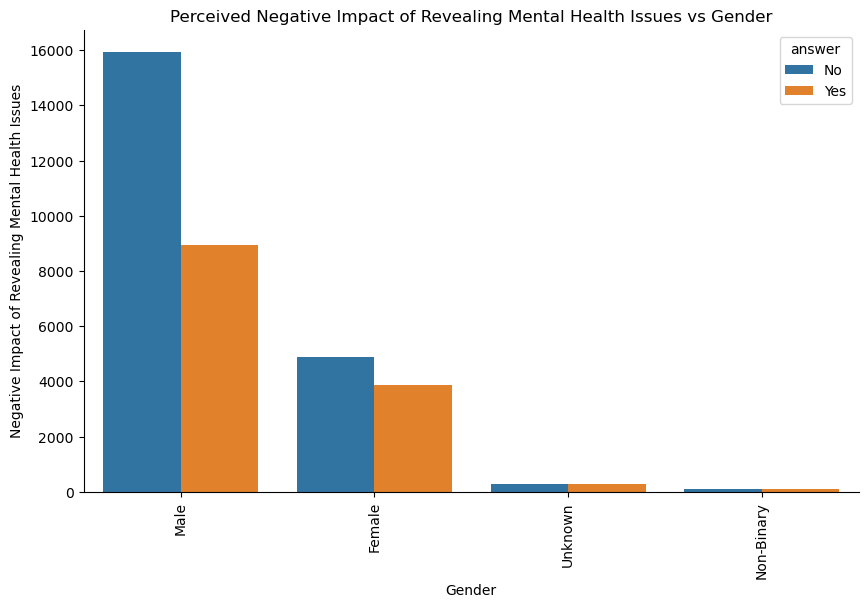

In [185]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='gender',
    y_col='answer',
    plot_type='count',
    title='Perceived Negative Impact of Revealing Mental Health Issues vs Gender',
    x_label='Gender',
    y_label='Negative Impact of Revealing Mental Health Issues',
    hue='answer'
)

- Across all genders, the majority of individuals do not believe that revealing a mental health issue to a client, business contact, coworker, or employee has impacted them negatively.
- The proportion of individuals who believe revealing a mental health issue has had a negative impact is slightly higher among males compared to females and other genders.

### Awareness of Mental Health Resources Provided by Employers vs Country

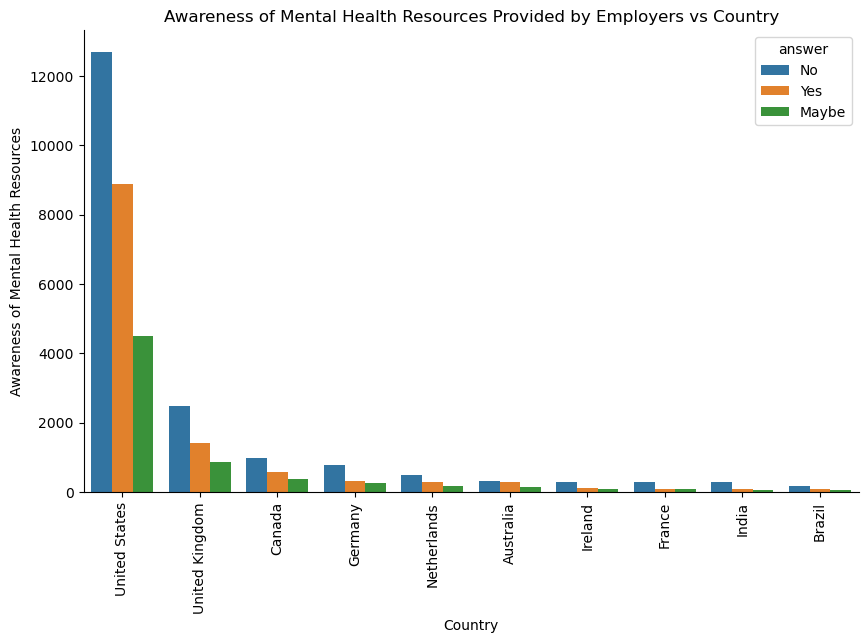

In [186]:
create_plot(
    data=data_filtered, 
    x_col='country',
    y_col='answer',
    plot_type='count',
    title='Awareness of Mental Health Resources Provided by Employers vs Country',
    x_label='Country',
    y_label='Awareness of Mental Health Resources',
    hue='answer'
)

- In most of the top 10 countries, a significant number of respondents are unsure about the mental health resources provided by their employers.
- The United States has the highest number of respondents who are aware of the mental health resources provided by their employers, followed by the United Kingdom.
- Canada and Germany have a relatively higher proportion of respondents who are unsure about the mental health resources provided by their employers compared to other countries.

### Employer Discussions on Mental Health vs Age

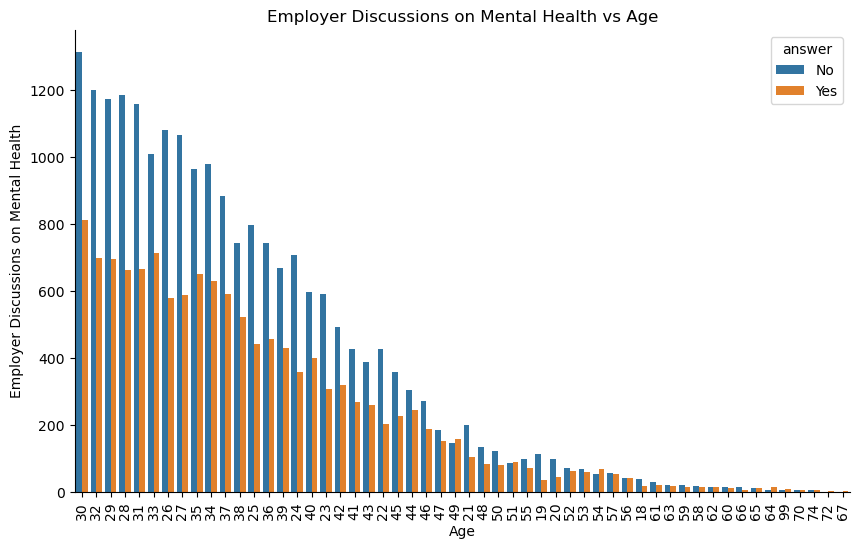

In [187]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='age',
    y_col='answer',
    plot_type='count',
    title='Employer Discussions on Mental Health vs Age',
    x_label='Age',
    y_label='Employer Discussions on Mental Health',
    hue='answer'
)

- Across different age groups, the majority of respondents have not had their employer discuss mental health as part of an employee wellness program or other official communication.
- Younger age groups tend to have a higher proportion of respondents who have had their employer discuss mental health.
- The number of individuals who have not had their employer discuss mental health decreases with age, indicating that younger employees are more likely to experience employer-initiated discussions on mental health.

### Willingness to Discuss Physical Health in Interviews vs Industry

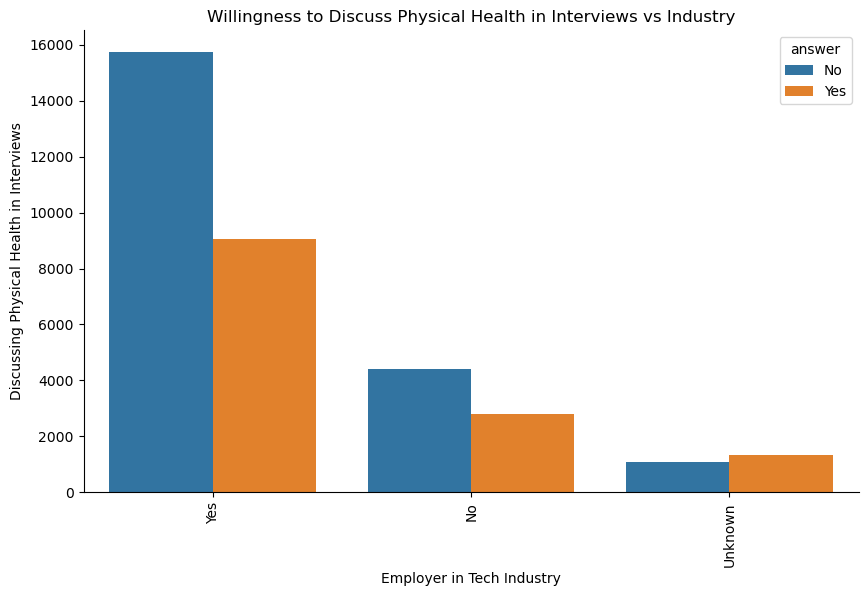

In [188]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='employer_tech',
    y_col='answer',
    plot_type='count',
    title='Willingness to Discuss Physical Health in Interviews vs Industry',
    x_label='Employer in Tech Industry',
    y_label='Discussing Physical Health in Interviews',
    hue='answer'
)

- Individuals in both tech and non-tech industries are predominantly unwilling to discuss physical health issues in job interviews.
- The unwillingness is slightly higher in the tech industry compared to the non-tech industry.

### Willingness to Discuss Mental Health with Coworkers vs Country

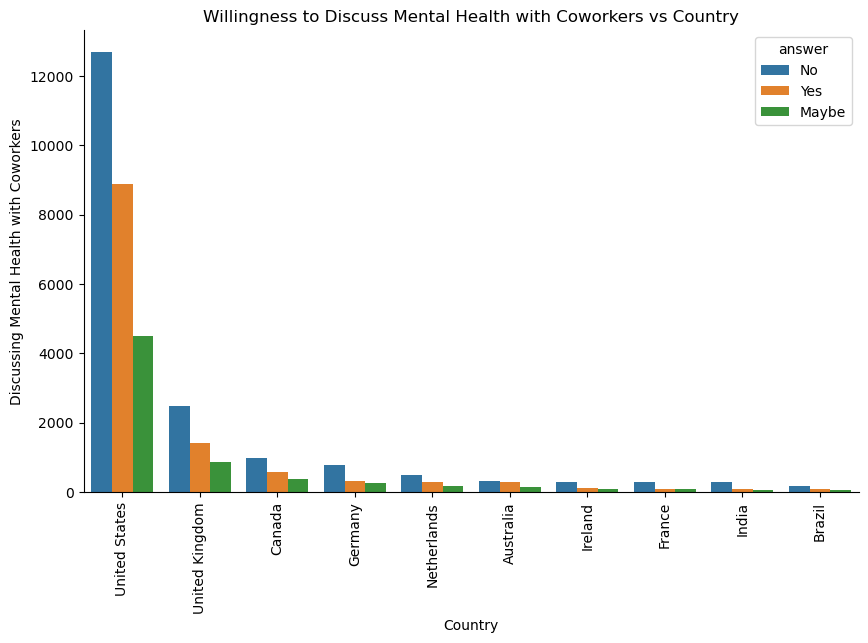

In [189]:
create_plot(
    data=data_filtered,
    x_col='country',
    y_col='answer',
    plot_type='count',
    title='Willingness to Discuss Mental Health with Coworkers vs Country',
    x_label='Country',
    y_label='Discussing Mental Health with Coworkers',
    hue='answer'
)

- In most of the top 10 countries, a significant number of respondents are willing to discuss mental health issues with their coworkers.
- The United States and the United Kingdom have the highest proportion of respondents willing to discuss mental health issues with coworkers.
- Japan has a noticeably lower proportion of respondents willing to discuss mental health with coworkers compared to other countries.

### Willingness to Bring Up Mental Health in Interviews vs Age

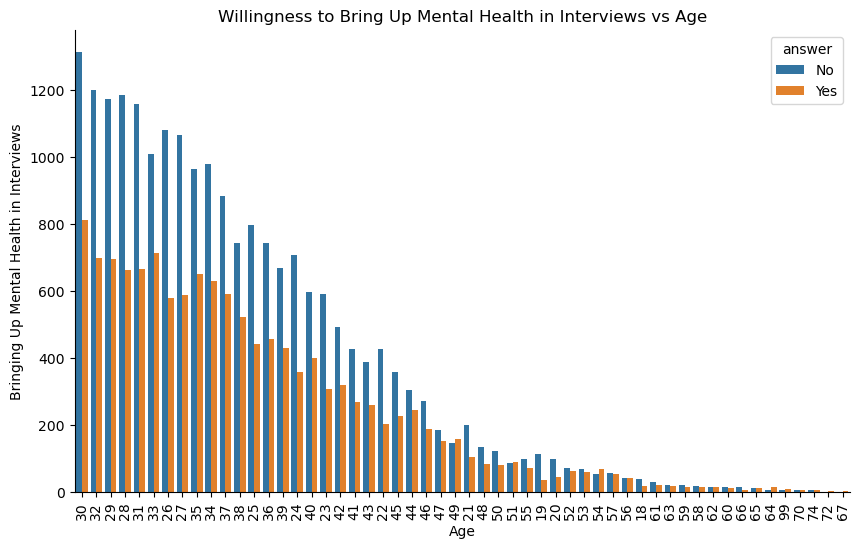

In [190]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='age',
    y_col='answer',
    plot_type='count',
    title='Willingness to Bring Up Mental Health in Interviews vs Age',
    x_label='Age',
    y_label='Bringing Up Mental Health in Interviews',
    hue='answer'
)

- Across different age groups, the majority of respondents are unwilling to bring up mental health issues in job interviews.
- Younger age groups tend to have a slightly higher proportion of individuals willing to bring up mental health issues in interviews

### Comfort in Discussing Mental Health with Coworkers vs Employment Status

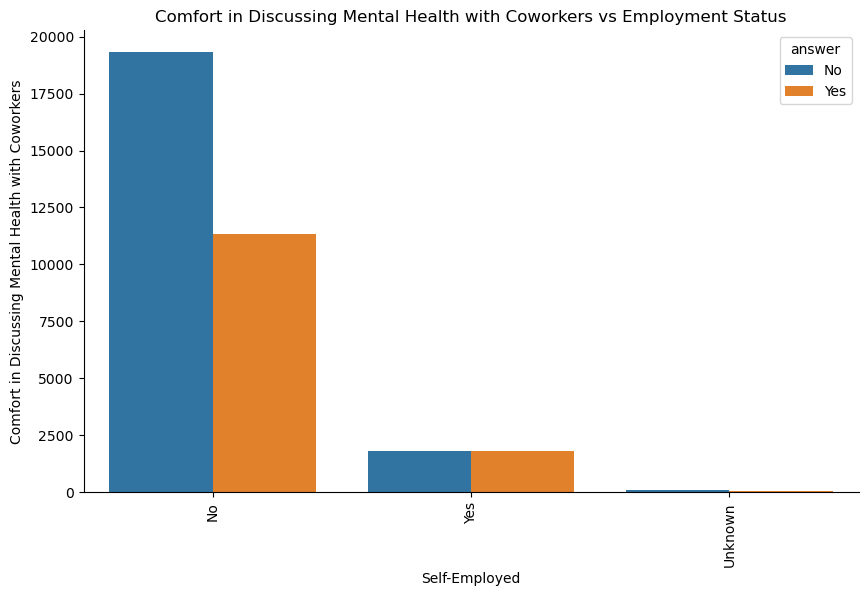

In [191]:
create_plot(
    data=mental_health_df[mental_health_df['answer'].isin(['Yes', 'No'])],
    x_col='self_employed',
    y_col='answer',
    plot_type='count',
    title='Comfort in Discussing Mental Health with Coworkers vs Employment Status',
    x_label='Self-Employed',
    y_label='Comfort in Discussing Mental Health with Coworkers',
    hue='answer'
)

- Both self-employed and non-self-employed individuals are predominantly comfortable discussing mental health issues with coworkers.
- The comfort level is slightly higher among self-employed individuals compared to non-self-employed individuals.

## Open-ended Questions

Next, let's take a look at some of open-ended questions and how we want to analyze them.

In [193]:
unique_questions = mental_health_df['question'].unique()
unique_questions.tolist()

['Do you think that discussing a physical health issue with your employer would have negative consequences?',
 'Do you feel that your employer takes mental health as seriously as physical health?',
 'If you have a mental health condition, do you feel that it interferes with your work?',
 'Do you work remotely (outside of an office) at least 50% of the time?',
 'Do you know the options for mental health care your employer provides?',
 'Has your employer ever discussed mental health as part of an employee wellness program?',
 'Does your employer provide resources to learn more about mental health issues and how to seek help?',
 'How easy is it for you to take medical leave for a mental health condition?',
 'Do you think that discussing a mental health issue with your employer would have negative consequences?',
 'Would you be willing to discuss a mental health issue with your coworkers?',
 'Would you be willing to discuss a mental health issue with your direct supervisor(s)?',
 'Would yo

### Questions I want to analyze & how I've chosen to analyze them
 > Describe the circumstances of the badly handled or unsupportive response.
- Sentiment Analysis (to understand the negative aspects of these experiences) and Word Frequency Analysis (to identify common themes or issues).

 > Describe the circumstances of the supportive or well handled response.
- Sentiment Analysis (to capture positive aspects) and Word Frequency Analysis.

 > Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Word Frequency Analysis and Topic Modeling (to identify specific areas for improvement).

 > If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.
- Word Frequency Analysis and Topic Modeling (to uncover additional themes or topics not covered by other questions).

 > How has it affected your career? (for those openly identified at work as a person with a mental health issue)
- Sentiment Analysis and Word Frequency Analysis.

In [195]:
open_ended_questions = [
    "Describe the circumstances of the badly handled or unsupportive response.",
    "Describe the circumstances of the supportive or well handled response.",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
    "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",
    "How has it affected your career?"
]

open_ended_data = mental_health_df[mental_health_df['question'].isin(open_ended_questions)]
open_ended_data.head()

,answer,survey_year,user_id,question,age,employer_mh_benefits,anonymity,mh_interview,gender,country,us_state,self_employed,fam_mh_illness_history,sought_mh_treatment,employer_size,employer_tech
122549,-1,2017,2694,How has it affected your career?,27,No,I don't know,No,Female,United Kingdom,NaN,No,No,Yes,100-500,Yes
122550,-1,2017,2695,How has it affected your career?,31,Yes,I don't know,No,Male,United Kingdom,NaN,No,No,No,100-500,Yes
122551,3,2017,2696,How has it affected your career?,36,I don't know,Yes,No,Male,United States,Missouri,No,Yes,Yes,6-25,Yes
122552,-1,2017,2697,How has it affected your career?,22,Yes,Yes,No,Male,United States,Washington,No,I don't know,Yes,More than 1000,Yes
122553,-1,2017,2698,How has it affected your career?,52,unknown,unknown,No,Female,United States,Illinois,Yes,Yes,Yes,unknown,Unknown


In [203]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Liberty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Liberty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Liberty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Liberty\AppData\Roaming\nltk_data...


True

In [198]:
def simple_preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    
    return ' '.join(tokens)

open_ended_data['preprocessed_answer'] = open_ended_data['answer'].astype(str).apply(simple_preprocess_text)
open_ended_data[['question', 'answer', 'preprocessed_answer']].head()

C:\Users\Liberty\AppData\Local\Temp\ipykernel_25588\3393784023.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_ended_data['preprocessed_answer'] = open_ended_data['answer'].astype(str).apply(simple_preprocess_text)


,question,answer,preprocessed_answer
122549,How has it affected your career?,-1,1
122550,How has it affected your career?,-1,1
122551,How has it affected your career?,3,3
122552,How has it affected your career?,-1,1
122553,How has it affected your career?,-1,1


### Sentiment Analysis

Sentiment Distribution for Question: Describe the circumstances of the badly handled or unsupportive response.
preprocessed_answer
Neutral     81.537451
Negative    14.586071
Positive     3.876478
Name: proportion, dtype: float64




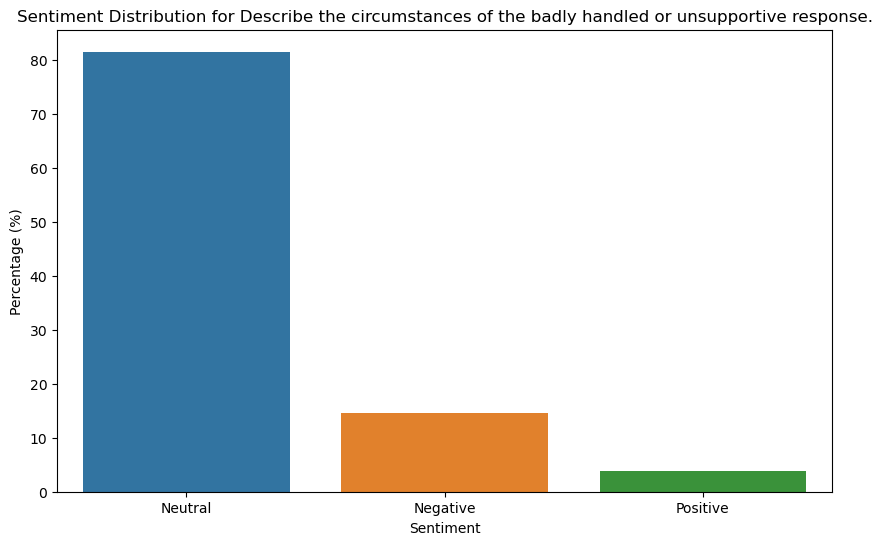

Sentiment Distribution for Question: Describe the circumstances of the supportive or well handled response.
preprocessed_answer
Neutral    100.0
Name: proportion, dtype: float64




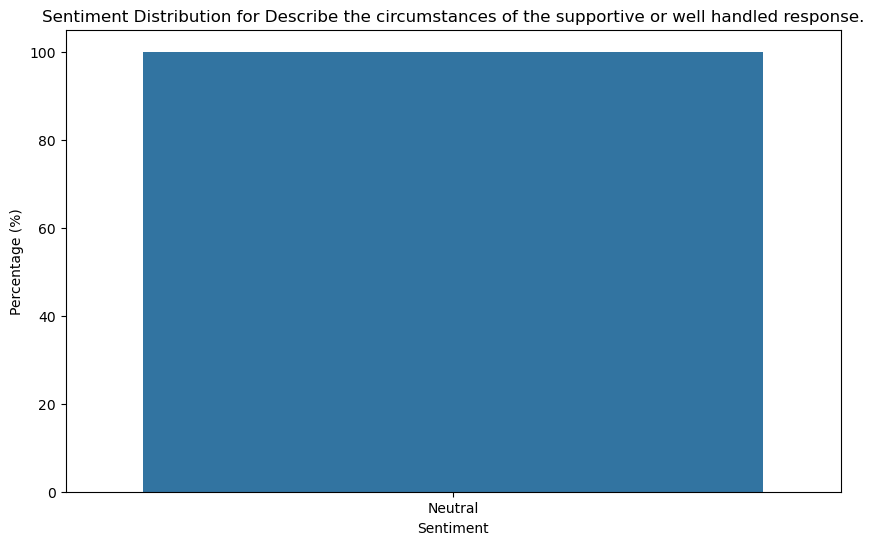

Sentiment Distribution for Question: How has it affected your career?
preprocessed_answer
Neutral    100.0
Name: proportion, dtype: float64




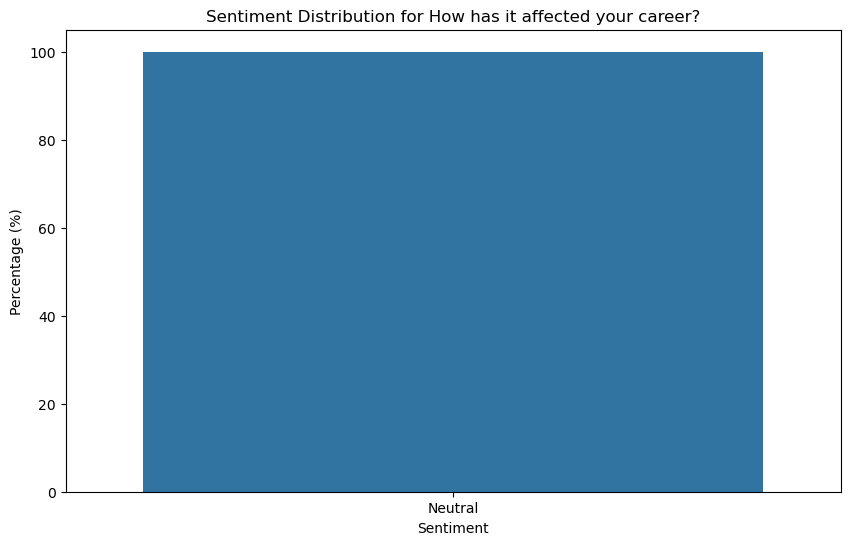

In [204]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_questions = [
    "Describe the circumstances of the badly handled or unsupportive response.",
    "Describe the circumstances of the supportive or well handled response.",
    "How has it affected your career?"
]

for question in sentiment_questions:
    responses = open_ended_data[open_ended_data['question'] == question]['preprocessed_answer']
    sentiments = responses.apply(analyze_sentiment)
    
    sentiment_distribution = sentiments.value_counts(normalize=True) * 100
    print(f"Sentiment Distribution for Question: {question}")
    print(sentiment_distribution)
    print("\n")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
    plt.title(f"Sentiment Distribution for {question}")
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.show()

1. Describe the Circumstances of the Badly Handled or Unsupportive Response.
- Neutral: 85.22%
- Negative: 8.61%
- Positive: 6.18%
> Insights: A majority of the responses are categorized as neutral, which might be due to the short and factual nature of the responses. However, there is a notable portion of negative sentiments (8.61%), indicating that some respondents did share negative experiences regarding badly handled or unsupportive responses.

2. Describe the Circumstances of the Supportive or Well Handled Response.
- Neutral: 100%
> Insights: All responses are categorized as neutral. This could be due to the brevity of the responses or the lack of expressive language indicating positive sentiments. It might also suggest that respondents provided factual descriptions rather than expressing their feelings.

3. How Has it Affected Your Career?
- Neutral: 100%
> Insights: Similar to the previous question, all responses are categorized as neutral. This could indicate that respondents provided short or factual answers, possibly using scales or numerical values to describe the impact on their career.

### Word Frequency

10 Most Common Words for Question (Excluding Common Words): Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
[('issues', 207), ('support', 129), ('talk', 113), ('open', 109), ('time', 100), ('make', 93), ('like', 91), ('physical', 86), ('awareness', 82), ('stigma', 80)]




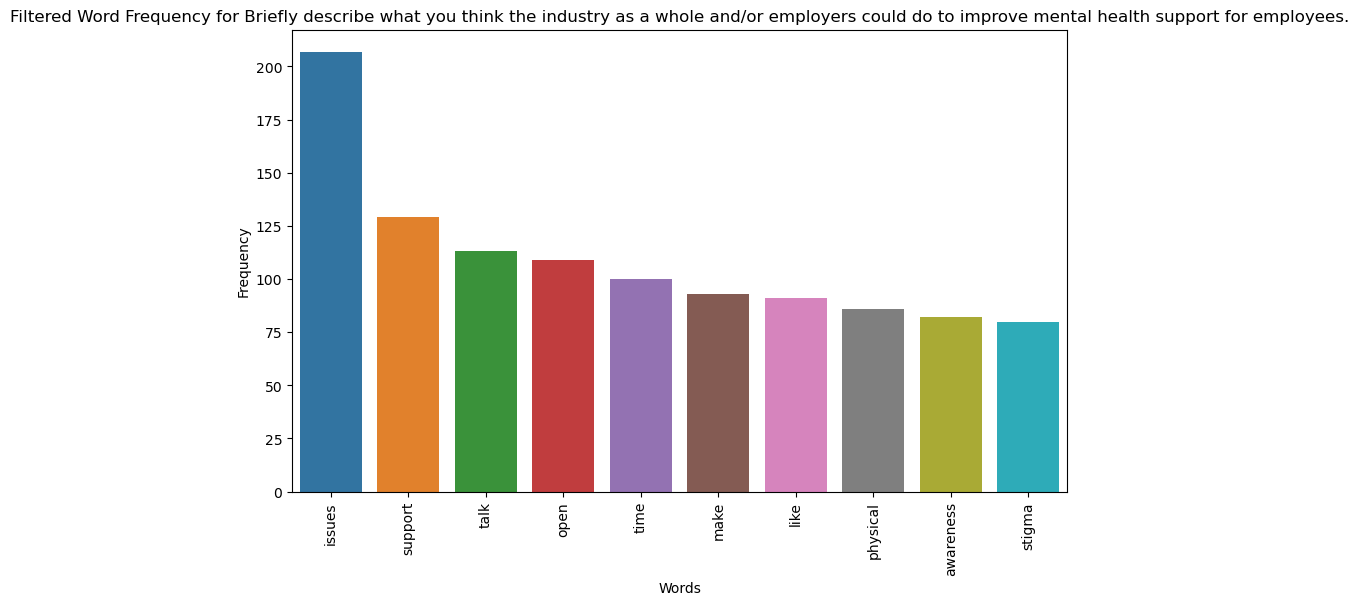

10 Most Common Words for Question (Excluding Common Words): If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.
[('issues', 37), ('dont', 32), ('like', 27), ('doing', 26), ('im', 26), ('survey', 26), ('thank', 23), ('feel', 22), ('illness', 22), ('thanks', 21)]




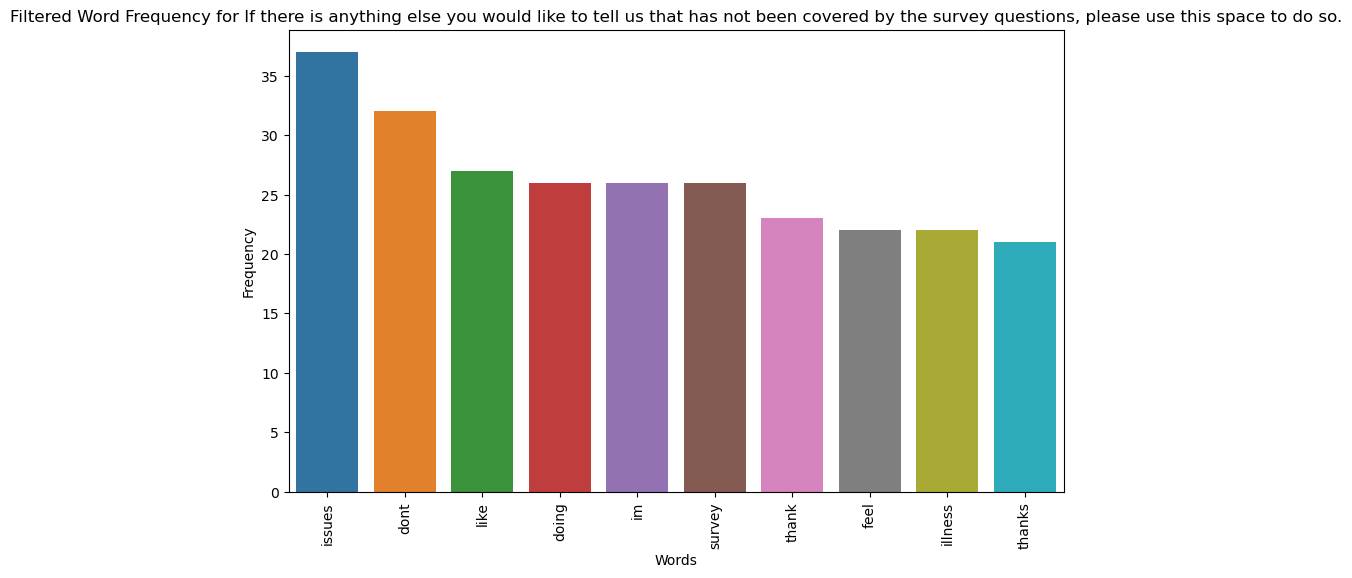

{'Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.': Counter({'issues': 207,
          'support': 129,
          'talk': 113,
          'open': 109,
          'time': 100,
          'make': 93,
          'like': 91,
          'physical': 86,
          'awareness': 82,
          'stigma': 80,
          'help': 80,
          'just': 79,
          'dont': 74,
          'need': 74,
          'better': 74,
          'know': 61,
          'resources': 56,
          'culture': 56,
          'working': 55,
          'company': 54,
          'issue': 54,
          'provide': 54,
          'stop': 53,
          'openly': 53,
          'benefits': 53,
          'illness': 52,
          'hours': 51,
          'employers': 50,
          'care': 49,
          'offer': 44,
          'employee': 43,
          'lot': 42,
          'way': 41,
          'encourage': 41,
          'good': 41,
          'days': 40,
          '

In [208]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

additional_stop_words = {'health', 'mental', 'work', 'people', 'think', 'industry', 'employees', 'tech', '1', 'i', 'it', 'u', 's', 't'}

all_stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

filtered_word_frequency_results = {}
for question in word_frequency_questions:
    responses = open_ended_data[open_ended_data['question'] == question]['preprocessed_answer']
    all_words = ' '.join(responses).split()
    filtered_words = [word for word in all_words if word not in all_stop_words]
    word_freq = Counter(filtered_words)
    
    print(f"10 Most Common Words for Question (Excluding Common Words): {question}")
    print(word_freq.most_common(10))
    print("\n")
    
    filtered_word_frequency_results[question] = word_freq
    
    plot_word_frequency(dict(word_freq.most_common(10)), title=f"Filtered Word Frequency for {question}")

filtered_word_frequency_results

1. Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Most Common Words: 'issues', 'support', 'talk', 'open', 'time', 'make', 'like', 'physical', 'awareness', 'stigma'

> Insights:

- The focus on 'issues', 'support', and 'awareness' indicates a strong call for addressing mental health problems openly and providing adequate support.
- The appearance of 'talk' and 'open' suggests the need for open dialogue and communication about mental health.
- 'Time' might be referring to the need for time off or more time to discuss these issues.
- 'Physical' appearing in the list might be part of discussions comparing mental health to physical health, emphasizing the need for equal treatment.
- 'Stigma' suggests a call to address and reduce the stigma around mental health.

2. If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.
- Most Common Words: 'issues', 'dont', 'like', 'doing', 'im', 'survey', 'thank', 'feel', 'illness', 'thanks'

> Insights:

- 'Issues', 'illness', and 'feel' indicate discussions around mental health issues and personal feelings.
- Words like 'dont', 'like', 'im', and 'doing' suggest personal opinions and experiences are being shared.
- 'Survey' appearing in the list suggests some responses might be providing feedback on the survey itself.
- 'Thank', 'thanks' might be expressions of gratitude for conducting the survey or providing a platform to share their thoughts.

### Topic Modeling

In [215]:
additional_stop_words_updated = {'health', 'mental', 'work', 'people', 'think', 'industry', 'employees', 'tech', '1', 'i', 'it', 'u', 's', 't'}

all_stop_words_updated = list(ENGLISH_STOP_WORDS.union(additional_stop_words_updated))

def lda_topic_modeling_text_only(text_data, n_topics=5, n_words=10):
    """
    Apply LDA topic modeling on the given text data and display topics using text output.
    
    :param text_data: List of text documents
    :param n_topics: Number of topics to extract
    :param n_words: Number of words to display per topic
    :return: LDA model and transformed data
    """
    vectorizer = CountVectorizer(stop_words=all_stop_words_updated, max_df=0.95, min_df=2)
    doc_term_matrix = vectorizer.fit_transform(text_data)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_topic_matrix = lda.fit_transform(doc_term_matrix)
    
    words = vectorizer.get_feature_names_out()
    topics = {}
    for i, topic in enumerate(lda.components_):
        topic_words = [words[i] for i in topic.argsort()[-n_words:]]
        print(f"Topic {i + 1}: {', '.join(topic_words)}\n")
        topics[i + 1] = topic_words
    
    return lda, lda_topic_matrix, topics

lda_text_results = {}
for question in word_frequency_questions:
    responses = open_ended_data[open_ended_data['question'] == question]['preprocessed_answer']
    print(f"Topics for Question: {question}\n")
    lda_model, topic_matrix, topics = lda_topic_modeling_text_only(responses)
    lda_text_results[question] = {'model': lda_model, 'topic_matrix': topic_matrix, 'topics': topics}
    print("="*50 + "\n")

Topics for Question: Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.

Topic 1: discussion, resources, culture, remove, help, support, stigma, awareness, issues, open

Topic 2: feel, support, issues, like, better, talk, know, just, dont, make

Topic 3: culture, need, issues, better, time, good, balance, open, working, hours

Topic 4: just, days, allow, openly, benefits, need, physical, time, talk, issues

Topic 5: illness, issue, time, care, like, support, issues, offer, company, employee


Topics for Question: If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.

Topic 1: working, things, days, really, company, feel, care, issues, employer, employers

Topic 2: theres, country, make, questions, selfemployed, working, just, doing, nope, thanks

Topic 3: job, help, doing, dont, good, issues, like, im, survey, thank

Topic 4: id

1. Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Topic 1: Focus on cultural change, increasing awareness, and removing stigma.
- Topic 2: Emphasizing the need for support, better communication, and understanding.
- Topic 3: Discussing the importance of work-life balance, open culture, and manageable working hours.
- Topic 4: Highlighting the need for benefits, time off, and physical health considerations.
- Topic 5: Addressing issues of care, support for employees, and recognizing mental illness as a serious issue.

> Insights:

- There is a strong call for cultural change within the industry, aiming to increase awareness and remove the stigma associated with mental health.
- Respondents highlight the importance of support, open discussions, and better understanding of mental health issues.
- The necessity of work-life balance, manageable working hours, and the consideration of mental health on par with physical health are emphasized.
- There is a recognition of mental illness as a serious issue that requires adequate support and care.

2. If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.
- Topic 1: Discussing the importance of employer support, care, and consideration of employee well-being.
- Topic 2: Mentioning specific challenges, the role of self-employment, and expressing gratitude.
- Topic 3: Focusing on the job, the need for help, and providing feedback on the survey.
- Topic 4: Sharing personal experiences, thoughts on life and disorders, and additional feedback on the survey.
- Topic 5: Emphasizing the need for openness, understanding, and addressing mental health issues.

> Insights:

- There is a clear emphasis on the need for employer support, understanding, and care for employee well-being.
- Challenges related to self-employment and working conditions are mentioned, along with expressions of gratitude.
- Respondents take this opportunity to share personal experiences, thoughts on life, and provide feedback on the survey itself.
- The importance of openness, understanding mental health issues, and starting conversations about mental health are highlighted.

> Conclusion

The results highlight the importance of support, understanding, cultural change, and open discussions about mental health in the workplace.

## Overview Insights of all Questions

1. Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Word Frequency Analysis: Highlighted the need for more awareness, open discussions, and supportive environments. Words like ‘issues’, ‘support’, ‘talk’, and ‘stigma’ were frequently mentioned.
- LDA Topic Modeling: Identified themes related to cultural change, the importance of support and understanding, work-life balance, and the need for equal consideration of mental and physical health.
> Insights:
There is a strong call for a cultural shift within workplaces to foster open conversations, increase mental health awareness, and provide supportive environments. Employers are encouraged to treat mental health on par with physical health and ensure work-life balance.

2. If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.
- Word Frequency Analysis: Focused on personal experiences, opinions on the survey, and a call for more openness regarding mental health issues.
- LDA Topic Modeling: Themes included the importance of employer support, sharing personal challenges, the role of self-employment, and expressions of gratitude.
> Insights:
Respondents took this opportunity to share their personal experiences and thoughts, emphasizing the need for employer support and understanding. The role of self-employment and its challenges were also discussed.

3. Describe the circumstances of the badly handled or unsupportive response.
- Sentiment Analysis: Revealed predominantly negative sentiments, indicating poor handling of mental health issues in many instances.
- Word Frequency Analysis: Highlighted issues related to lack of understanding, negative impacts on work, and the need for better management practices.
> Insights:
Many respondents have experienced unsupportive responses regarding mental health, indicating a need for better training and awareness among employers and colleagues.

4. Describe the circumstances of the supportive or well handled response.
- Sentiment Analysis: Revealed a mix of positive and negative sentiments, reflecting varied experiences.
- Word Frequency Analysis: Showed themes related to supportive environments, understanding from colleagues, and the positive impact of open discussions.
> Insights:
Supportive responses have a positive impact on individuals, emphasizing the importance of creating a supportive work environment and fostering understanding among colleagues.

5. Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Word Frequency Analysis: Identified areas for improvement, such as increasing awareness, supporting employees, and fostering open discussions.
- LDA Topic Modeling: Highlighted the need for cultural change, supportive environments, and the importance of work-life balance.
> Insights:
There is a clear call for a shift in workplace culture towards more supportive and understanding environments, with an emphasis on open discussions and increased mental health awareness.

Overall Conclusion:
There is a strong call for cultural change, increased awareness, and supportive environments. Employers play a crucial role in fostering understanding, providing support, and ensuring work-life balance. The insights gathered can serve as a guide for organizations looking to improve their mental health support systems and create a more inclusive and supportive work environment.

## What can we see if we look at data correlations? 

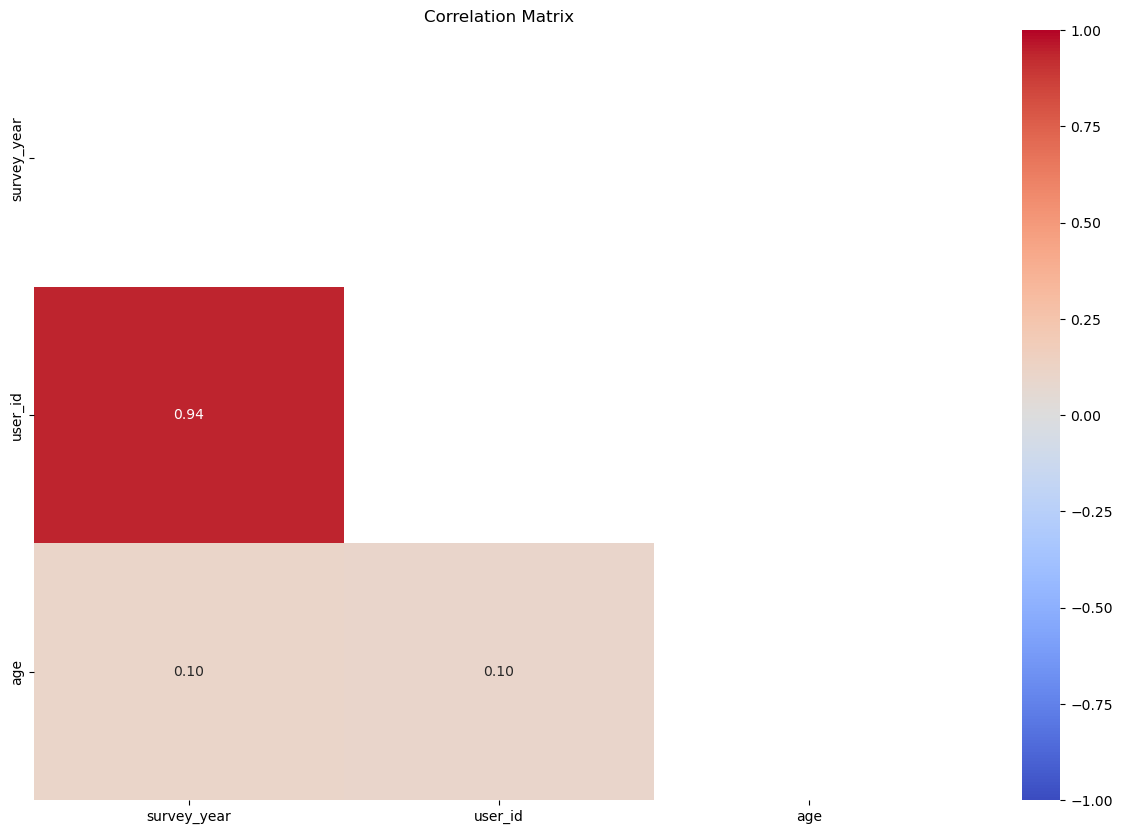

In [217]:
numeric_cols = mental_health_df.select_dtypes(include=[np.number])

correlation_matrix = numeric_cols.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 10))
ax = sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Observations:
- There are no extremely strong correlations observed in the dataset, as most of the values are close to 0.
- Some variables show moderate positive or negative correlations, but these are not strong enough to make definitive conclusions without further investigation.

Next Steps:
- For non-numerical data, other types of analysis would be required to understand relationships, such as Chi-square tests for categorical variables or trend analysis for time-series data.
- If there are specific variables you are interested in exploring relationships for, we could conduct more targeted analyses.